In [1]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import io
import re


from dataclasses import dataclass
from typing import Literal, Dict, Any

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from scipy import stats


from IPython.display import display

import tomllib
import joblib

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

NOTEBOOK_DIR = Path("")

ARTIFACTS_DIR = NOTEBOOK_DIR / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"
CONFIG_DIR = NOTEBOOK_DIR / "config"
DATA_DIR = NOTEBOOK_DIR / "data"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CONFIG_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

print("Notebook dir:", NOTEBOOK_DIR.resolve())
print("Artifacts dir:", ARTIFACTS_DIR.resolve())
print("Config dir:", CONFIG_DIR.resolve())
print("Data dir:", DATA_DIR.resolve())

Notebook dir: /root/source/awesome-ai-engineer/homeworks/HW07
Artifacts dir: /root/source/awesome-ai-engineer/homeworks/HW07/artifacts
Config dir: /root/source/awesome-ai-engineer/homeworks/HW07/config
Data dir: /root/source/awesome-ai-engineer/homeworks/HW07/data


In [3]:
def deep_merge(base: dict[str, Any], override: dict[str, Any]) -> dict[str, Any]:
    out = dict(base)
    for k, v in override.items():
        if k in out and isinstance(out[k], dict) and isinstance(v, dict):
            out[k] = deep_merge(out[k], v)
        else:
            out[k] = v
    return out


def require_type(path: str, value: Any, t: type) -> None:
    if not isinstance(value, t):
        raise TypeError(f"{path}: expected {t.__name__}, got {type(value).__name__}")

def require_literal(path: str, value: Any, allowed: set[str]) -> None:
    require_type(path, value, str)
    if value not in allowed:
        raise ValueError(f"{path}: expected one of {sorted(allowed)}, got {value!r}")

def require_list_of(path: str, value: Any, elem_type: type) -> None:
    require_type(path, value, list)
    for i, x in enumerate(value):
        if not isinstance(x, elem_type):
            raise TypeError(f"{path}[{i}]: expected {elem_type.__name__}, got {type(x).__name__}")

def require_float_in_0_1(path: str, value: Any) -> None:
    if not isinstance(value, (float, int)):
        raise TypeError(f"{path}: expected float, got {type(value).__name__}")
    v = float(value)
    if not (0.0 < v <= 1.0):
        raise ValueError(f"{path}: expected 0 < value <= 1, got {v}")

In [4]:
def _is_dict(x: Any) -> bool:
    return isinstance(x, dict)


def find_unknown_keys(
    base: dict[str, Any],
    override: dict[str, Any],
    prefix: str = "",
) -> list[str]:
    unknown: list[str] = []

    for k, v in override.items():
        path = f"{prefix}.{k}" if prefix else k

        if k not in base:
            unknown.append(path)
            continue

        base_v = base[k]

        if _is_dict(base_v) and _is_dict(v):
            unknown.extend(find_unknown_keys(base_v, v, path))
        elif _is_dict(v) and not _is_dict(base_v):
            unknown.append(path)
    return unknown


def assert_no_unknown_keys(
    base: dict[str, Any],
    override: dict[str, Any],
    *,
    context: str = "override",
) -> None:
    bad = find_unknown_keys(base, override)
    if bad:
        bad_sorted = "\n  - " + "\n  - ".join(sorted(bad))
        raise KeyError(
            f"Найдены неизвестные ключи в {context} (скорее всего опечатка или придуманный параметр):"
            f"{bad_sorted}"
        )


def find_missing_required_keys(
    base: dict[str, Any],
    merged: dict[str, Any],
    prefix: str = "",
) -> list[str]:
    missing: list[str] = []
    for k, base_v in base.items():
        path = f"{prefix}.{k}" if prefix else k
        if k not in merged:
            missing.append(path)
            continue
        merged_v = merged[k]
        if _is_dict(base_v):
            if not _is_dict(merged_v):
                missing.append(path)
            else:
                missing.extend(find_missing_required_keys(base_v, merged_v, path))
    return missing


def assert_no_missing_required_keys(base: dict[str, Any], merged: dict[str, Any]) -> None:
    miss = find_missing_required_keys(base, merged)
    if miss:
        miss_sorted = "\n  - " + "\n  - ".join(sorted(miss))
        raise KeyError(
            "После объединения конфигов отсутствуют обязательные ключи (повреждена структура конфига):"
            f"{miss_sorted}"
        )


In [5]:
Scaling = Literal["standard", "minmax", "robust", "none"]
PCAMode = Literal["fixed", "variance"]
DBSCANMetric = Literal["euclidean", "manhattan", "cosine"]
AggMetric = Literal["euclidean", "manhattan", "cosine"]


@dataclass(frozen=True)
class PCAConfig:
    enabled: bool
    mode: PCAMode
    n_components: int
    explained_variance: float


@dataclass(frozen=True)
class ScalingColumns:
    method: Scaling
    columns: list[str]


@dataclass(frozen=True)
class PreprocessConfig:
    scaling: list[ScalingColumns]
    pca: PCAConfig


@dataclass(frozen=True)
class KMeansGrid:
    ks: list[int]
    n_init: list[int]
    max_iter: list[int]


@dataclass(frozen=True)
class DBSCANGrid:
    eps: list[float]
    min_samples: list[int]
    metric: DBSCANMetric


@dataclass(frozen=True)
class AgglomerativeGrid:
    ks: list[int]
    linkages: list[str]
    metric: AggMetric


@dataclass(frozen=True)
class Grids:
    kmeans: KMeansGrid
    dbscan: DBSCANGrid
    agglomerative: AgglomerativeGrid


@dataclass(frozen=True)
class SearchConfig:
    grids: Grids


@dataclass(frozen=True)
class EvaluationConfig:
    metrics: list[str]


@dataclass(frozen=True)
class RuntimeConfig:
    random_state: int
    n_jobs: int


@dataclass(frozen=True)
class Config:
    preprocess: PreprocessConfig
    search: SearchConfig
    evaluation: EvaluationConfig
    runtime: RuntimeConfig


In [6]:
def parse_config(d: dict[str, Any]) -> Config:
    # preprocess
    pp = d.get("preprocess", {})
    require_type("preprocess", pp, dict)

    scaling = pp.get("scaling")
    require_type("preprocess.scaling", scaling, list)

    pca_d = pp.get("pca", {})
    require_type("preprocess.pca", pca_d, dict)

    enabled = pca_d.get("enabled")
    require_type("preprocess.pca.enabled", enabled, bool)

    mode = pca_d.get("mode")
    require_literal("preprocess.pca.mode", mode, {"fixed", "variance"})

    n_components = pca_d.get("n_components")
    require_type("preprocess.pca.n_components", n_components, int)

    explained_variance = pca_d.get("explained_variance")
    require_float_in_0_1("preprocess.pca.explained_variance", explained_variance)

    if mode == "fixed" and n_components <= 0:
        raise ValueError("preprocess.pca.n_components must be > 0 when mode='fixed'")
    if mode == "variance" and not (0.0 < float(explained_variance) <= 1.0):
        raise ValueError("preprocess.pca.explained_variance must be in (0,1] when mode='variance'")

    preprocess = PreprocessConfig(
        scaling=scaling,  # type: ignore[arg-type]
        pca=PCAConfig(
            enabled=enabled,
            mode=mode,  # type: ignore[arg-type]
            n_components=n_components,
            explained_variance=float(explained_variance),
        ),
    )

    # search grids
    search = d.get("search", {})
    require_type("search", search, dict)

    grids = search.get("grids", {})
    require_type("search.grids", grids, dict)

    # kmeans
    km = grids.get("kmeans", {})
    require_type("search.grids.kmeans", km, dict)
    require_list_of("search.grids.kmeans.ks", km.get("ks"), int)
    require_list_of("search.grids.kmeans.n_init", km.get("n_init"), int)
    require_list_of("search.grids.kmeans.max_iter", km.get("max_iter"), int)

    kmeans_grid = KMeansGrid(ks=km["ks"], n_init=km["n_init"], max_iter=km["max_iter"])

    # dbscan
    db = grids.get("dbscan", {})
    require_type("search.grids.dbscan", db, dict)
    require_list_of("search.grids.dbscan.eps", db.get("eps"), float)
    require_list_of("search.grids.dbscan.min_samples", db.get("min_samples"), int)
    require_literal("search.grids.dbscan.metric", db.get("metric"), {"euclidean", "manhattan", "cosine"})
    dbscan_grid = DBSCANGrid(eps=db["eps"], min_samples=db["min_samples"], metric=db["metric"])  # type: ignore[arg-type]

    # agglomerative
    ag = grids.get("agglomerative", {})
    require_type("search.grids.agglomerative", ag, dict)
    require_list_of("search.grids.agglomerative.ks", ag.get("ks"), int)
    require_list_of("search.grids.agglomerative.linkages", ag.get("linkages"), str)
    require_literal("search.grids.agglomerative.metric", ag.get("metric"), {"euclidean", "manhattan", "cosine"})
    agg_metric = ag["metric"]

    # бизнес-ограничение: ward требует euclidean
    if "ward" in ag["linkages"] and agg_metric != "euclidean":
        raise ValueError("search.grids.agglomerative: linkage 'ward' requires metric='euclidean'")

    agglomerative_grid = AgglomerativeGrid(ks=ag["ks"], linkages=ag["linkages"], metric=agg_metric)  # type: ignore[arg-type]

    search_cfg = SearchConfig(
        grids=Grids(kmeans=kmeans_grid, dbscan=dbscan_grid, agglomerative=agglomerative_grid)
    )

    # evaluation
    ev = d.get("evaluation", {})
    require_type("evaluation", ev, dict)
    require_list_of("evaluation.metrics", ev.get("metrics"), str)
    evaluation = EvaluationConfig(metrics=ev["metrics"])

    # runtime
    rt = d.get("runtime", {})
    require_type("runtime", rt, dict)
    require_type("runtime.random_state", rt.get("random_state"), int)
    require_type("runtime.n_jobs", rt.get("n_jobs"), int)
    runtime = RuntimeConfig(random_state=rt["random_state"], n_jobs=rt["n_jobs"])

    return Config(preprocess=preprocess, search=search_cfg, evaluation=evaluation, runtime=runtime)


def load_config(base_path: str | Path, dataset_path: str | Path) -> Config:
    base = tomllib.loads(Path(base_path).read_text(encoding="utf-8"))
    override = tomllib.loads(Path(dataset_path).read_text(encoding="utf-8"))
    assert_no_unknown_keys(base, override, context=f"{dataset_path}")
    merged = deep_merge(base, override)
    assert_no_missing_required_keys(base, merged)
    return parse_config(merged)

In [7]:
def _safe_filename(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_\-\.]+", "", s)
    return s[:200] if len(s) > 200 else s


def _ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

In [8]:
def _normality_tests(x: np.ndarray, shapiro_max_n: int = 5000) -> Dict[str, Any]:
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = int(x.size)

    out: Dict[str, Any] = {"n": n}
    if n < 8:
        out.update(
            {
                "shapiro_stat": np.nan,
                "shapiro_p": np.nan,
                "dagostino_stat": np.nan,
                "dagostino_p": np.nan,
                "anderson_stat": np.nan,
                "anderson_crit_5pct": np.nan,
            }
        )
        return out

    # Shapiro-Wilk
    if n > shapiro_max_n:
        rng = np.random.default_rng(42)
        xs = rng.choice(x, size=shapiro_max_n, replace=False)
    else:
        xs = x

    try:
        sh_stat, sh_p = stats.shapiro(xs)
    except Exception:
        sh_stat, sh_p = np.nan, np.nan

    # D'Agostino-Pearson (normaltest):
    try:
        dg_stat, dg_p = stats.normaltest(x)
    except Exception:
        dg_stat, dg_p = np.nan, np.nan

    # Anderson-Darling
    try:
        ad = stats.anderson(x, dist="norm")
        crit_5 = np.nan
        if 5 in ad.significance_level.tolist():
            idx = ad.significance_level.tolist().index(5)
            crit_5 = float(ad.critical_values[idx])
        out.update(
            {
                "anderson_stat": float(ad.statistic),
                "anderson_crit_5pct": crit_5,
            }
        )
    except Exception:
        out.update(
            {
                "anderson_stat": np.nan,
                "anderson_crit_5pct": np.nan,
            }
        )

    out.update(
        {
            "shapiro_stat": float(sh_stat) if np.isfinite(sh_stat) else np.nan,
            "shapiro_p": float(sh_p) if np.isfinite(sh_p) else np.nan,
            "dagostino_stat": float(dg_stat) if np.isfinite(dg_stat) else np.nan,
            "dagostino_p": float(dg_p) if np.isfinite(dg_p) else np.nan,
        }
    )
    return out


def get_dataset_visual_analysis(
    df: pd.DataFrame,
    dataset_name: str = "hw_dataset",
    max_unique_for_hist_bins: int = 200,
    shapiro_max_n: int = 5000,
    show_plots: bool = True,
    save_plots: bool = True,
    run_normality: bool = True,
) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=np.number)
    results = []

    for column in numeric_df.columns:
        col_safe = _safe_filename(column)
        x = numeric_df[column].to_numpy()
        x = x[np.isfinite(x)]
        n = int(x.size)

        skew = float(stats.skew(x, bias=False)) if n >= 3 else np.nan
        kurt = float(stats.kurtosis(x, fisher=True, bias=False)) if n >= 4 else np.nan

        tests = _normality_tests(x, shapiro_max_n=shapiro_max_n) if run_normality else {"n": n}
        row = {
            "column": column,
            "n": n,
            "skewness": skew,
            "kurtosis_excess": kurt,
            **tests,
        }
        results.append(row)

        # --- BOX PLOT ---
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.boxplot(x, vert=True)
        ax.set_title(f"Box plot of {column}")
        ax.set_ylabel("Values")
        if save_plots:
            fig.savefig(FIGURES_DIR / f"{dataset_name}_box_plot_{col_safe}.png", bbox_inches="tight", dpi=150)
        if show_plots:
            plt.show()
        plt.close(fig)

        # --- HISTOGRAM ---
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 1, 1)

        uniq = np.unique(x).size
        if uniq <= max_unique_for_hist_bins:
            bins = min(uniq, 30) if uniq > 1 else 1
        else:
            bins = 30

        ax.hist(x, bins=bins)
        ax.set_title(f"Histogram of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
        if save_plots:
            fig.savefig(FIGURES_DIR / f"{dataset_name}_hist_{col_safe}.png", bbox_inches="tight", dpi=150)
        if show_plots:
            plt.show()
        plt.close(fig)

        # --- Q-Q PLOT ---
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1)
        stats.probplot(x, dist="norm", plot=ax)
        ax.set_title(f"Q-Q plot of {column}")
        if save_plots:
            fig.savefig(FIGURES_DIR / f"{dataset_name}_qq_{col_safe}.png", bbox_inches="tight", dpi=150)
        if show_plots:
            plt.show()
        plt.close(fig)

    report_df = pd.DataFrame(results)

    if save_plots:
        report_df.to_csv(ARTIFACTS_DIR / f"{dataset_name}_numeric_columns_distribution_report.csv", index=False)

    return report_df


def df_report(
    df: pd.DataFrame,
    dataset_name: str = "hw_dataset",
    n_head: int = 5,
    show_plots: bool = True,
    save_plots: bool = True,
    run_normality: bool = True,
):
    buf = io.StringIO()
    df.info(buf=buf)

    print(f"=== DataFrame name: {dataset_name} ===")
    print(f"=== DataFrame shape: {df.shape} ===")
    print("=== DataFrame.info() ===")
    print(buf.getvalue())

    print(f"=== DataFrame.head({n_head}) ===")
    display(df.head(n_head))

    print("=== DataFrame.describe(include='all') ===")
    display(df.describe(include="all"))

    dist_report = get_dataset_visual_analysis(
        df,
        dataset_name=dataset_name,
        show_plots=show_plots,
        save_plots=save_plots,
        run_normality=run_normality,
    )

    print("=== Numeric columns distribution report (skew/kurtosis + normality tests) ===")
    if "shapiro_p" in dist_report.columns:
        display(dist_report.sort_values(["shapiro_p", "n"], ascending=[True, False]))
    else:
        display(dist_report)


In [9]:
# loading datasets
dataset_one = pd.read_csv(DATA_DIR / "S07-hw-dataset-01.csv", index_col='sample_id')
dataset_two = pd.read_csv(DATA_DIR / "S07-hw-dataset-02.csv", index_col='sample_id')
dataset_three = pd.read_csv(DATA_DIR / "S07-hw-dataset-03.csv", index_col='sample_id')

=== DataFrame name: hw07_ds1 ===
=== DataFrame shape: (12000, 8) ===
=== DataFrame.info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f01     12000 non-null  float64
 1   f02     12000 non-null  float64
 2   f03     12000 non-null  float64
 3   f04     12000 non-null  float64
 4   f05     12000 non-null  float64
 5   f06     12000 non-null  float64
 6   f07     12000 non-null  float64
 7   f08     12000 non-null  float64
dtypes: float64(8)
memory usage: 843.8 KB

=== DataFrame.head(5) ===


,f01,f02,f03,f04,f05,f06,f07,f08
sample_id,,,,,,,,
0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


=== DataFrame.describe(include='all') ===


,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


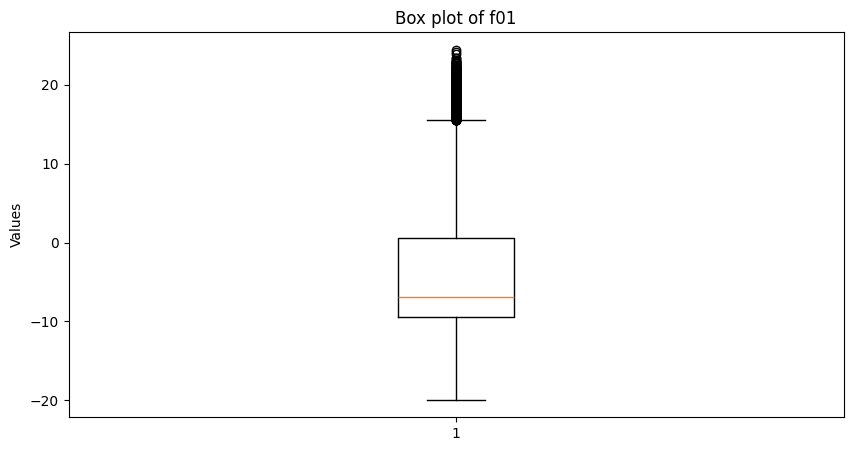

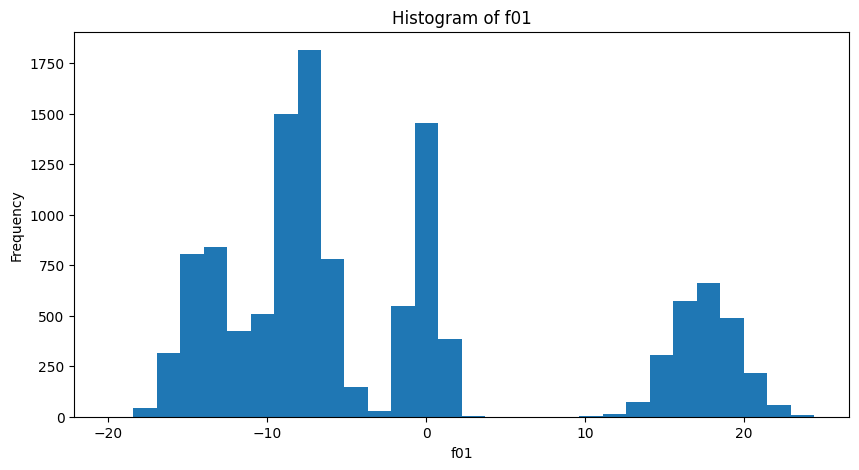

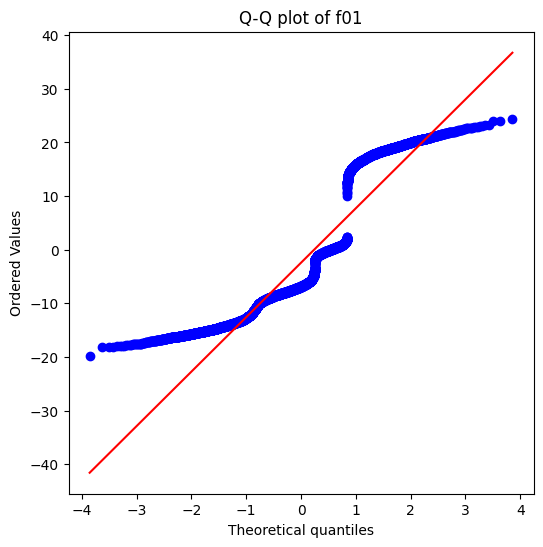

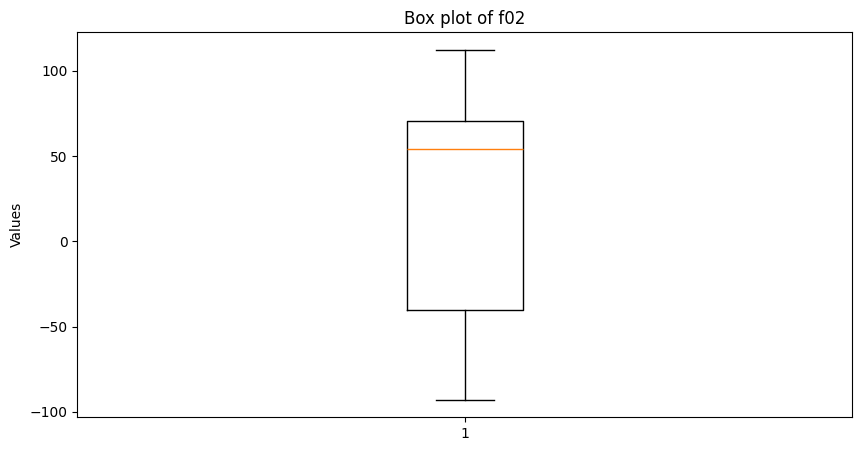

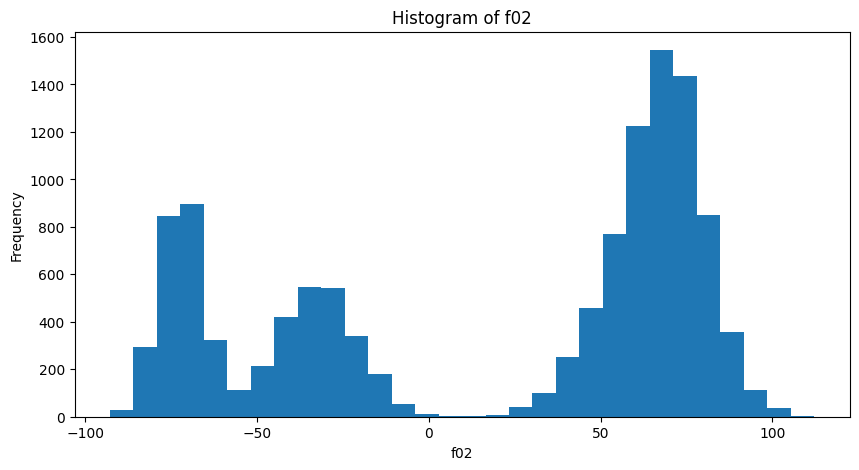

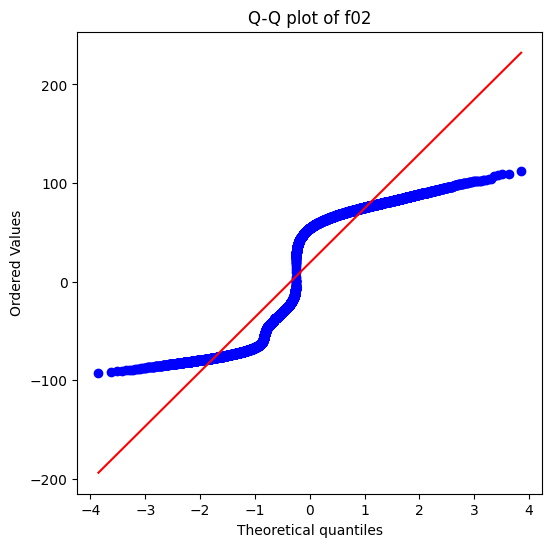

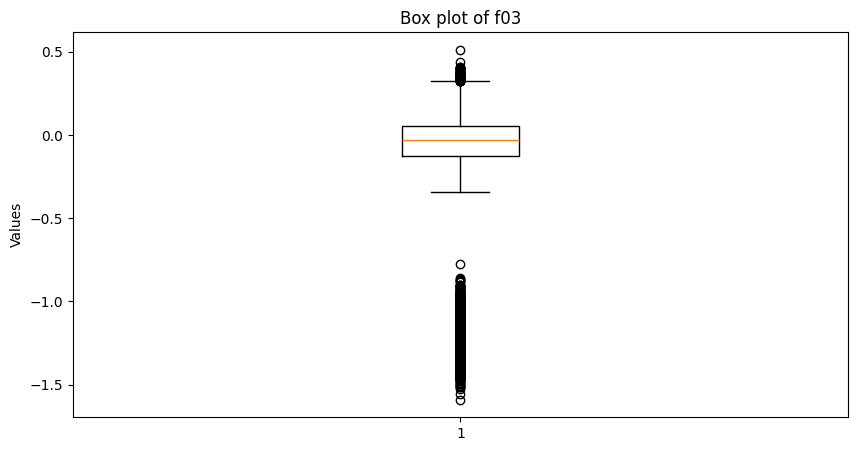

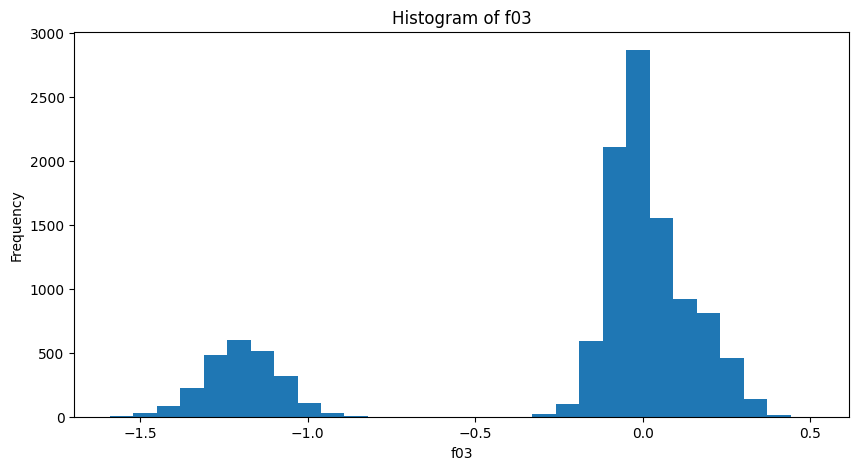

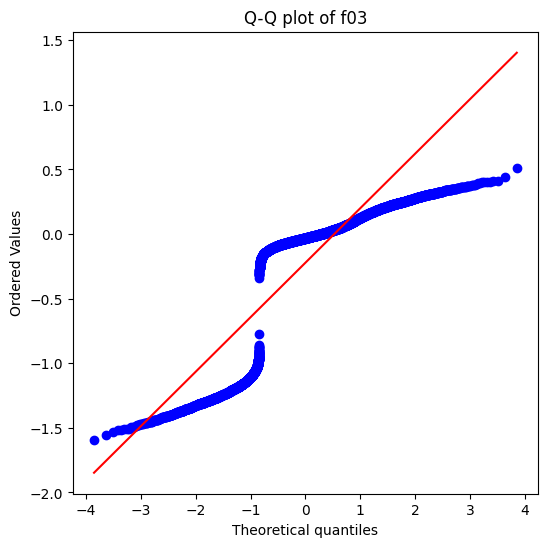

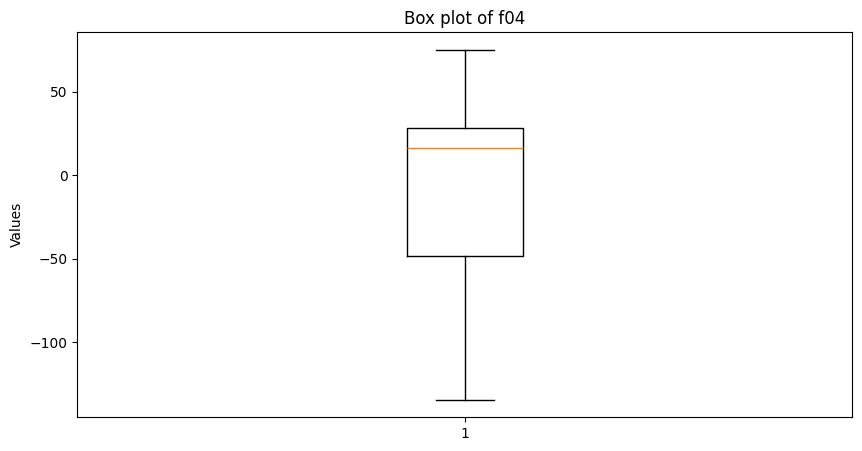

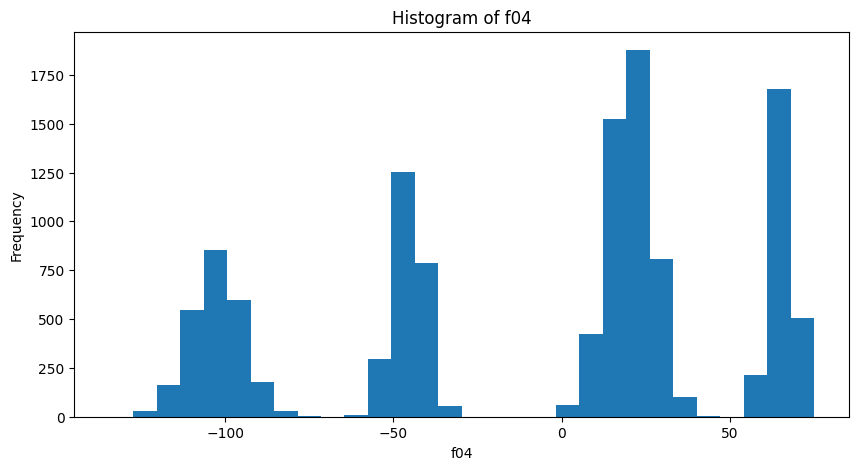

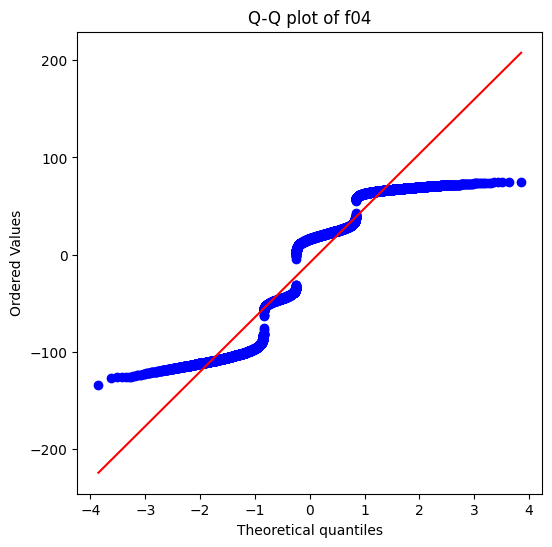

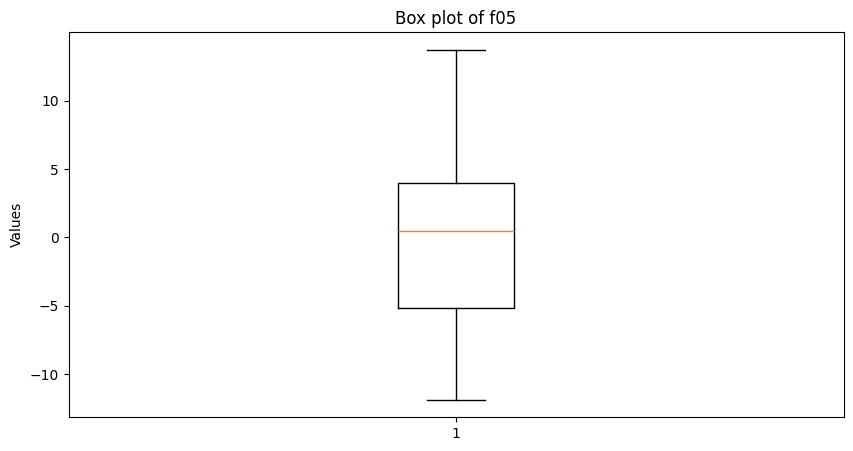

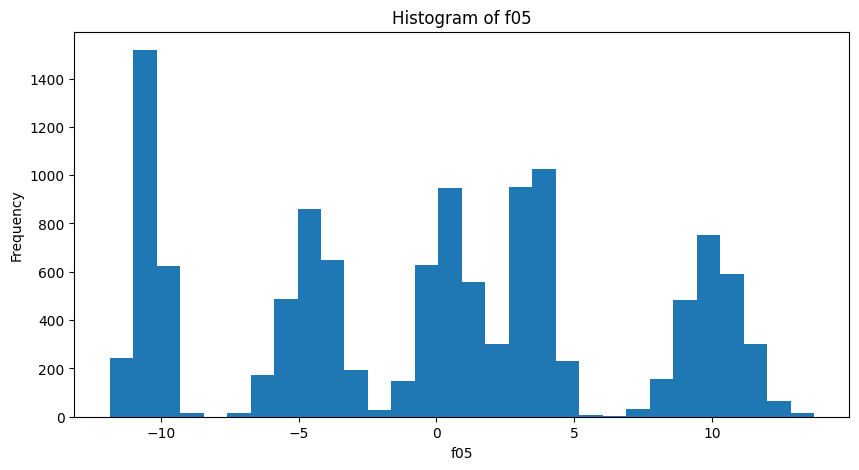

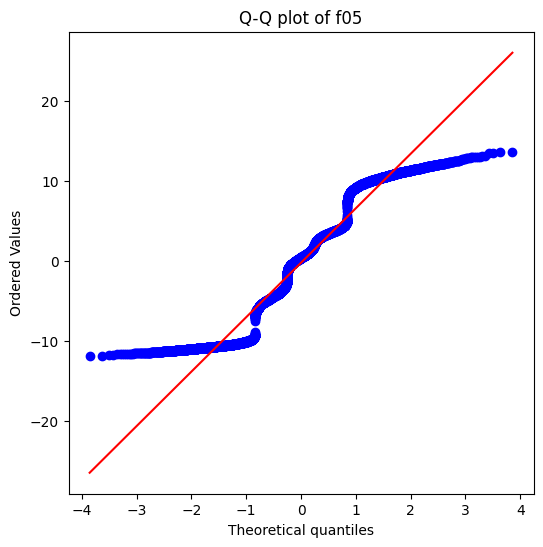

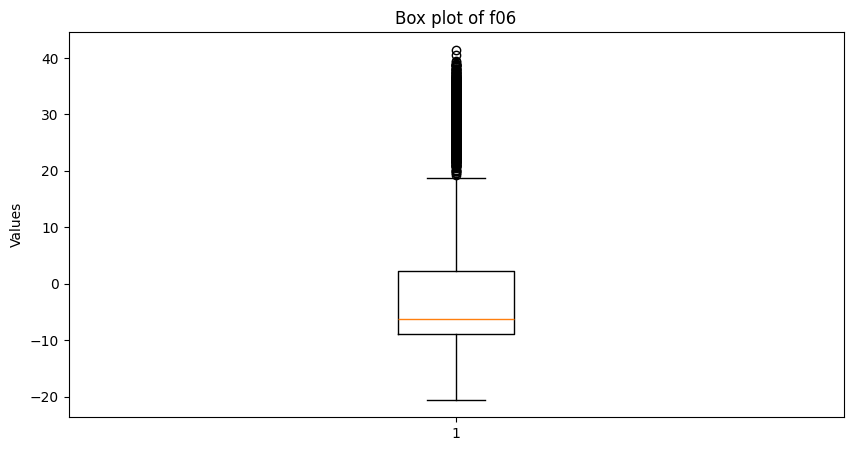

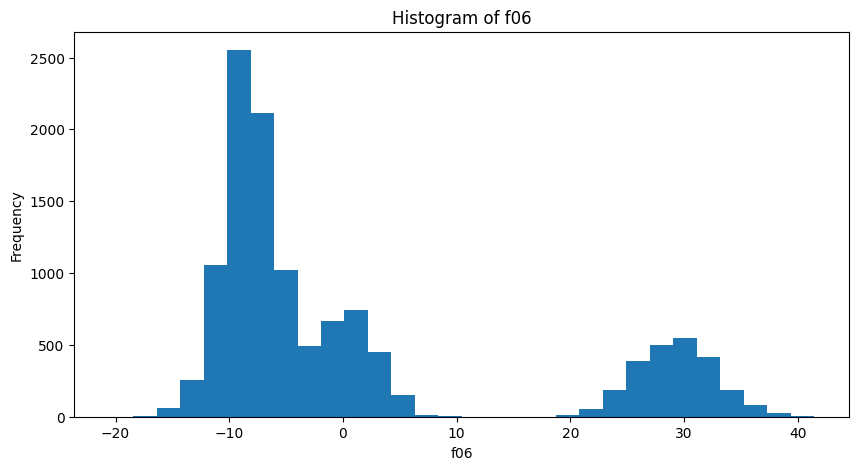

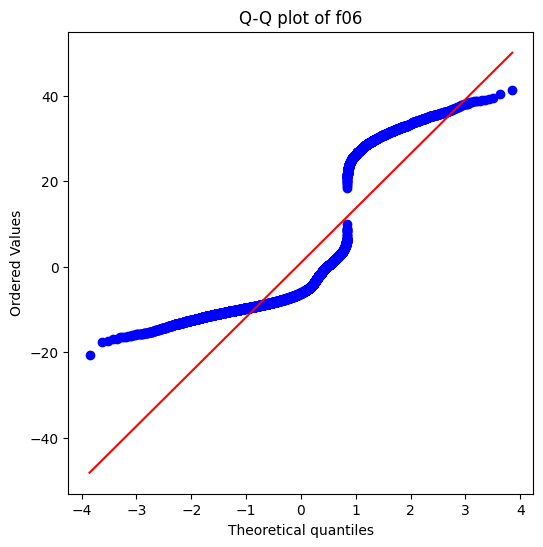

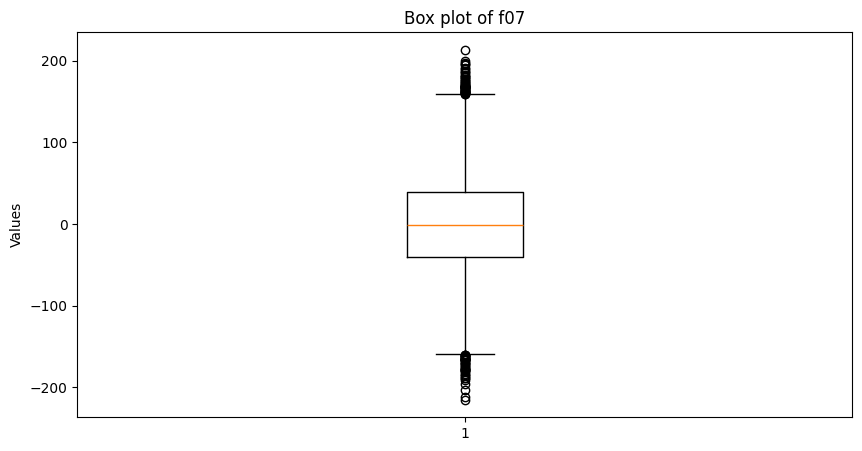

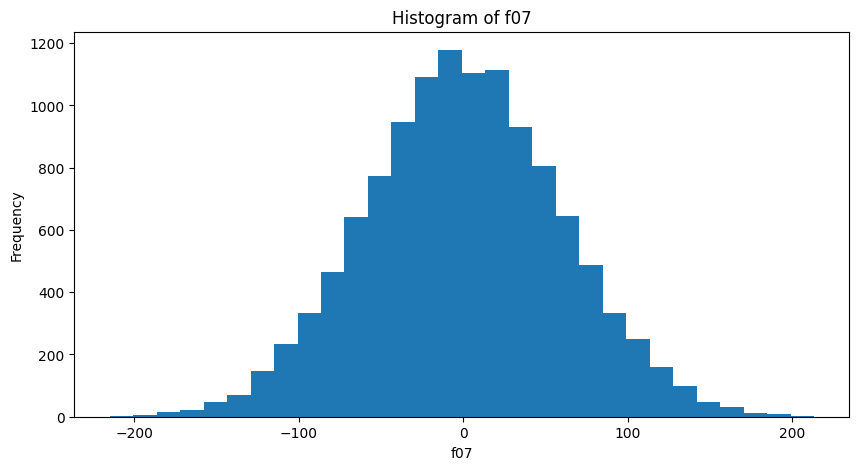

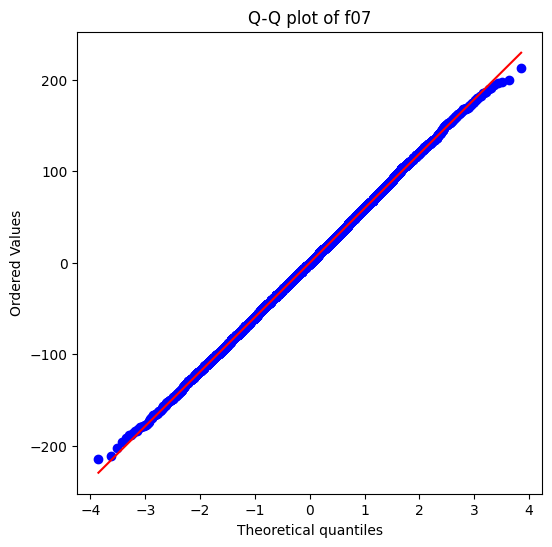

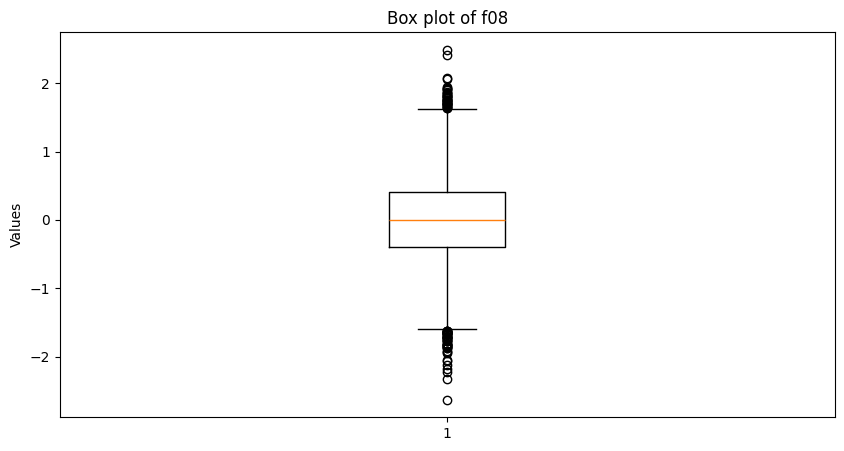

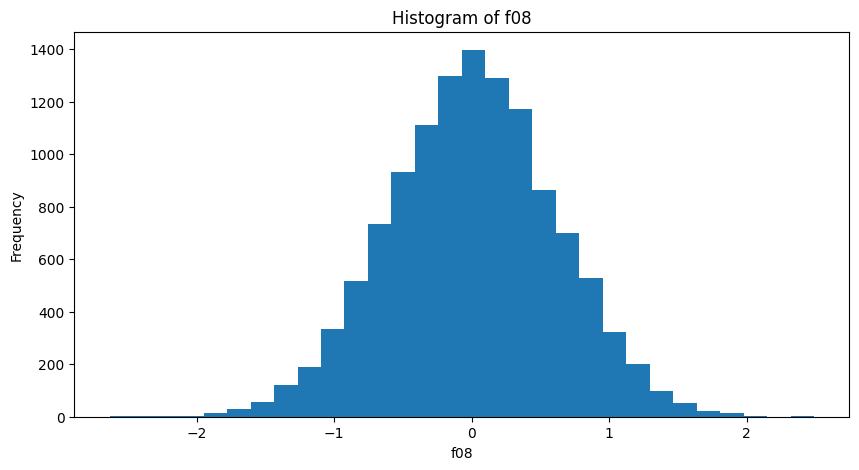

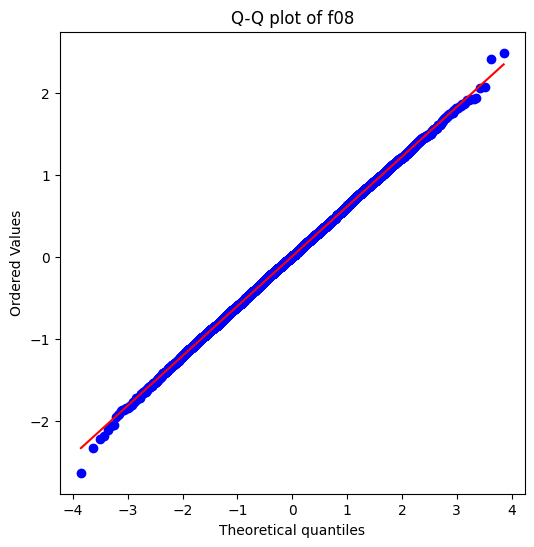

=== Numeric columns distribution report (skew/kurtosis + normality tests) ===


,column,n,skewness,kurtosis_excess,anderson_stat,anderson_crit_5pct,shapiro_stat,shapiro_p,dagostino_stat,dagostino_p
2,f03,12000,-1.368658,0.216797,1650.890531,0.787,0.703867,3.117549e-69,2237.609324,0.000000e+00
5,f06,12000,1.284645,0.048467,1360.474275,0.787,0.733904,4.190350e-67,2037.476837,0.000000e+00
1,f02,12000,-0.472649,-1.492298,911.697048,0.787,0.823976,3.355166e-59,75072.181785,0.000000e+00
0,f01,12000,0.933227,-0.408917,712.193618,0.787,0.847841,1.552317e-56,1414.155927,8.316531e-308
3,f04,12000,-0.434129,-1.113783,485.519602,0.787,0.895066,5.040525e-50,5728.761475,0.000000e+00
4,f05,12000,-0.002320,-1.055391,190.736273,0.787,0.940214,5.998836e-41,3741.617234,0.000000e+00
6,f07,12000,0.023856,-0.033961,0.419704,0.787,0.999668,6.085392e-01,1.702954,4.267840e-01
7,f08,12000,-0.017439,0.016560,0.334633,0.787,0.999710,7.368413e-01,0.760806,6.835859e-01


In [10]:
df_report(dataset_one, dataset_name='hw07_ds1')

=== DataFrame name: hw07_ds2 ===
=== DataFrame shape: (8000, 3) ===
=== DataFrame.info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x1       8000 non-null   float64
 1   x2       8000 non-null   float64
 2   z_noise  8000 non-null   float64
dtypes: float64(3)
memory usage: 250.0 KB

=== DataFrame.head(5) ===


,x1,x2,z_noise
sample_id,,,
0,0.098849,-1.846034,21.288122
1,-1.024516,1.829616,6.072952
2,-1.094178,-0.158545,-18.938342
3,-1.612808,-1.565844,-11.629462
4,1.659901,-2.133292,1.895472


=== DataFrame.describe(include='all') ===


,x1,x2,z_noise
count,8000.000000,8000.000000,8000.000000
mean,0.478867,0.241112,0.110454
std,0.955138,0.663195,8.097716
min,-2.487352,-2.499237,-34.056074
25%,-0.116516,-0.242357,-5.392210
50%,0.490658,0.241092,0.132470
75%,1.085263,0.726526,5.655605
max,2.987555,2.995553,29.460076


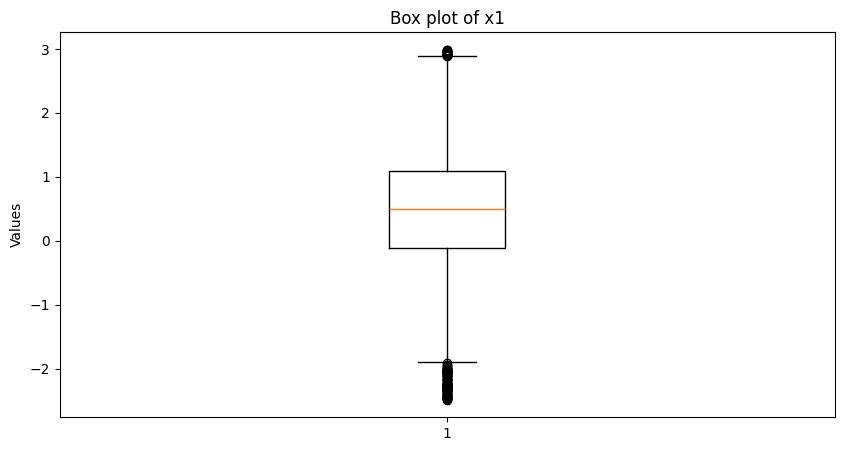

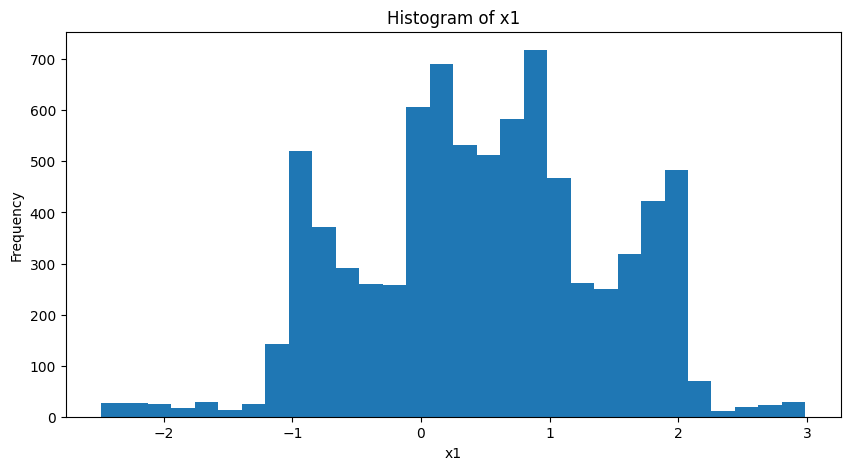

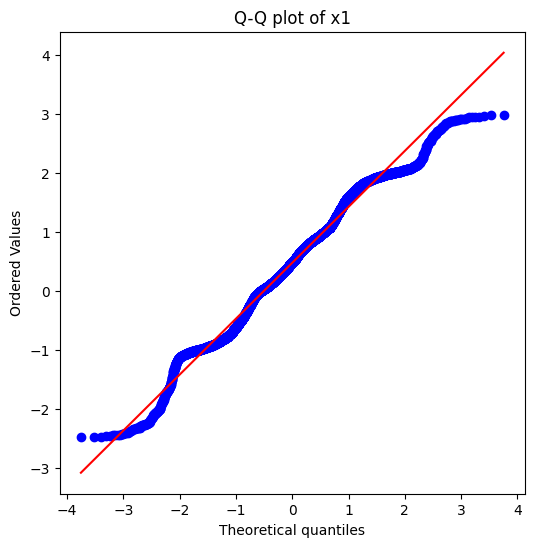

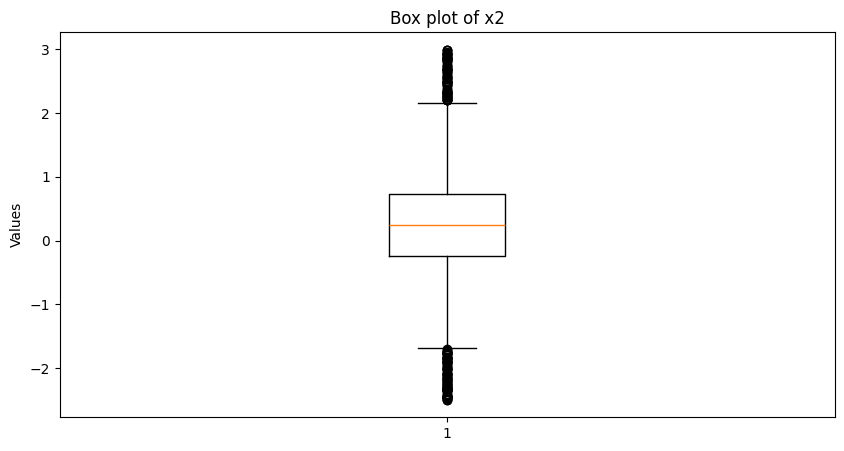

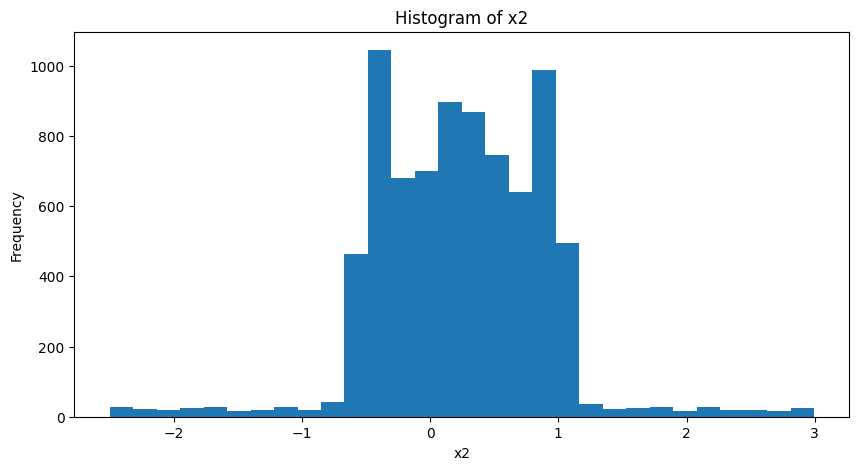

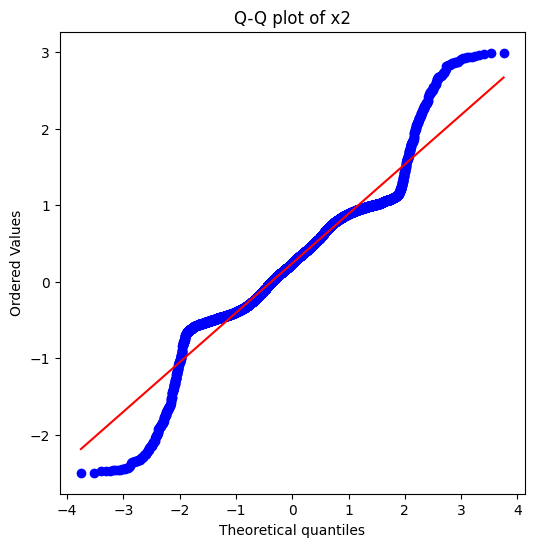

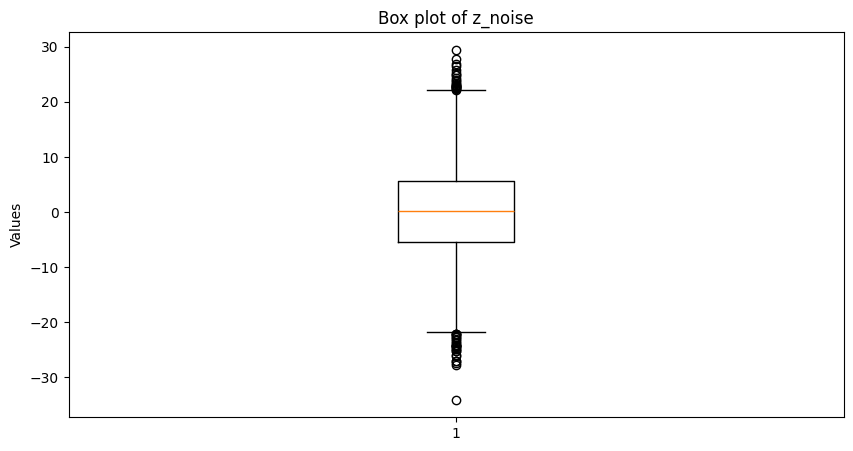

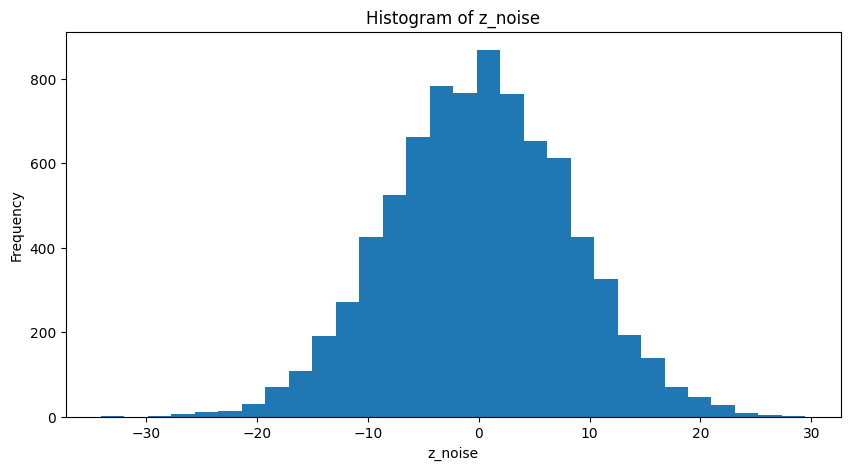

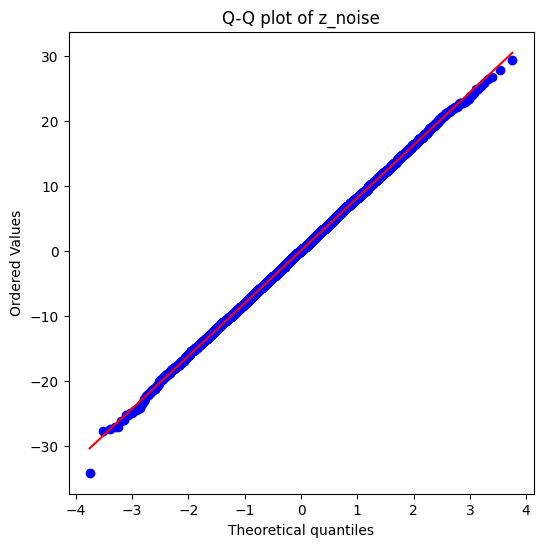

=== Numeric columns distribution report (skew/kurtosis + normality tests) ===


,column,n,skewness,kurtosis_excess,anderson_stat,anderson_crit_5pct,shapiro_stat,shapiro_p,dagostino_stat,dagostino_p
1,x2,8000,-0.064045,2.456755,57.375215,0.787,0.951488,8.117985e-38,470.579978,6.529142e-103
0,x1,8000,-0.136598,-0.364317,25.419122,0.787,0.986082,8.289231e-22,91.530686,1.331570e-20
2,z_noise,8000,-0.001737,-0.014602,0.184754,0.787,0.999787,9.252602e-01,0.062429,9.692677e-01


In [11]:
df_report(dataset_two, dataset_name='hw07_ds2')

=== DataFrame name: hw07_ds3 ===
=== DataFrame shape: (15000, 4) ===
=== DataFrame.info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x1       15000 non-null  float64
 1   x2       15000 non-null  float64
 2   f_corr   15000 non-null  float64
 3   f_noise  15000 non-null  float64
dtypes: float64(4)
memory usage: 585.9 KB

=== DataFrame.head(5) ===


,x1,x2,f_corr,f_noise
sample_id,,,,
0,-2.710470,4.997107,-1.015703,0.718508
1,8.730238,-8.787416,3.953063,-1.105349
2,-1.079600,-2.558708,0.976628,-3.605776
3,6.854042,1.560181,1.760614,-1.230946
4,9.963812,-8.869921,2.966583,0.915899


=== DataFrame.describe(include='all') ===


,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.246296,1.033764,0.212776,-0.027067
std,4.592421,4.710791,1.530017,2.506375
min,-9.995585,-9.980853,-5.212038,-8.785884
25%,-1.782144,-2.666393,-0.966224,-1.731128
50%,0.664226,1.831257,0.296508,-0.052391
75%,4.435671,4.969630,1.390273,1.673831
max,16.207863,14.271153,5.795876,11.266865


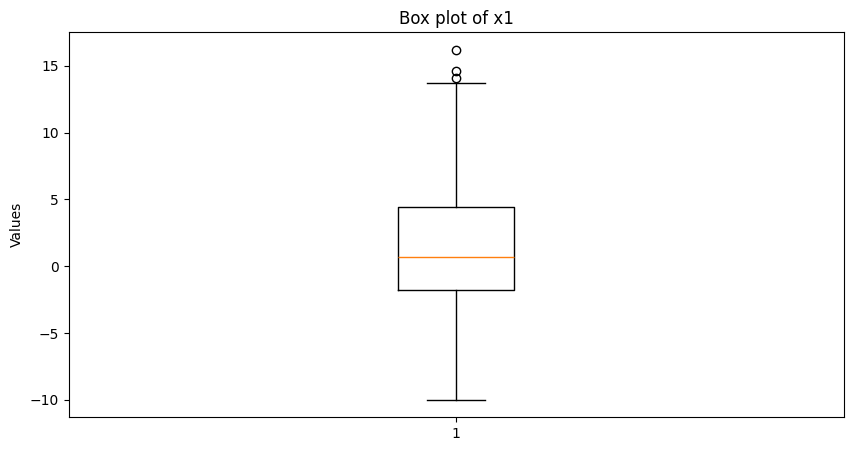

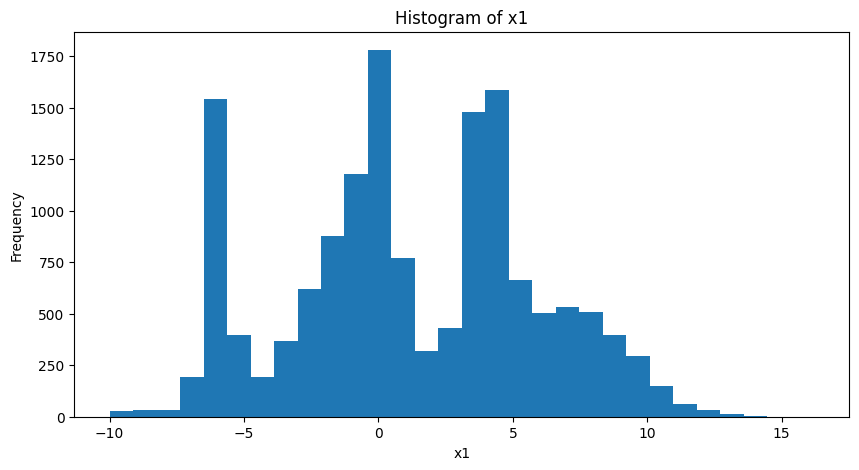

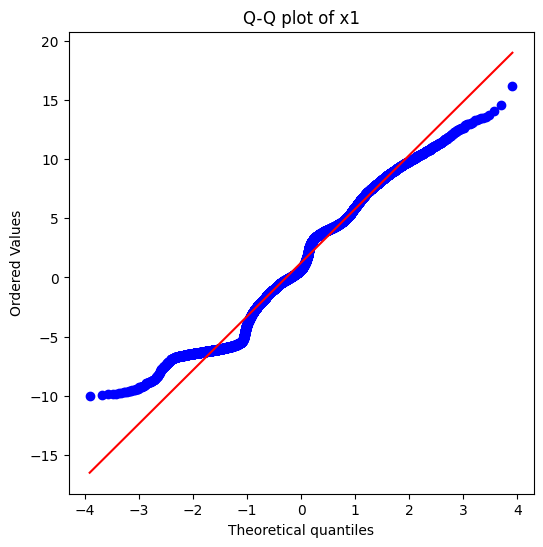

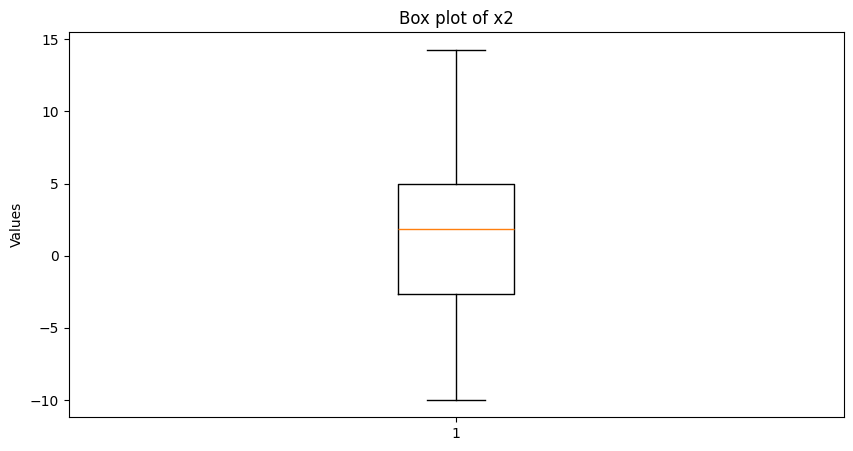

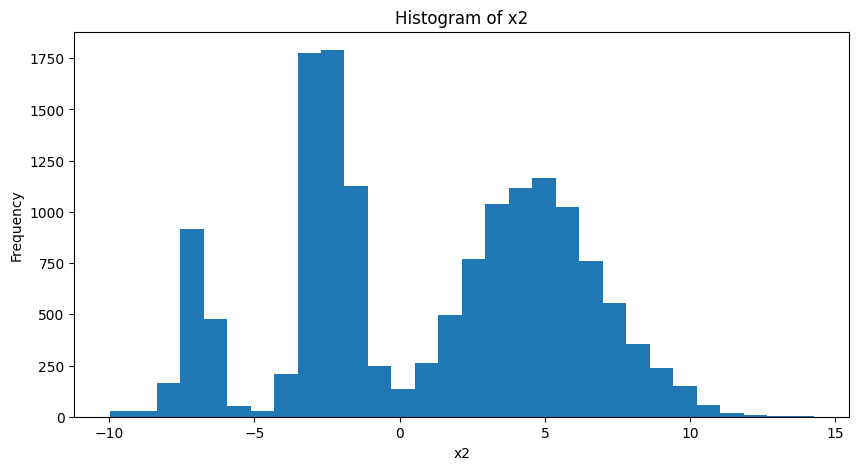

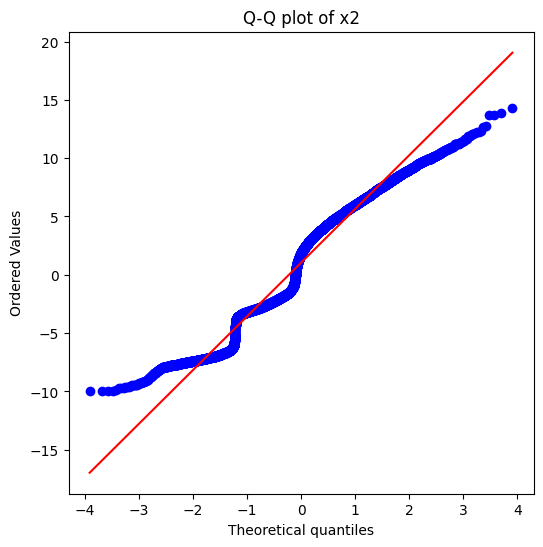

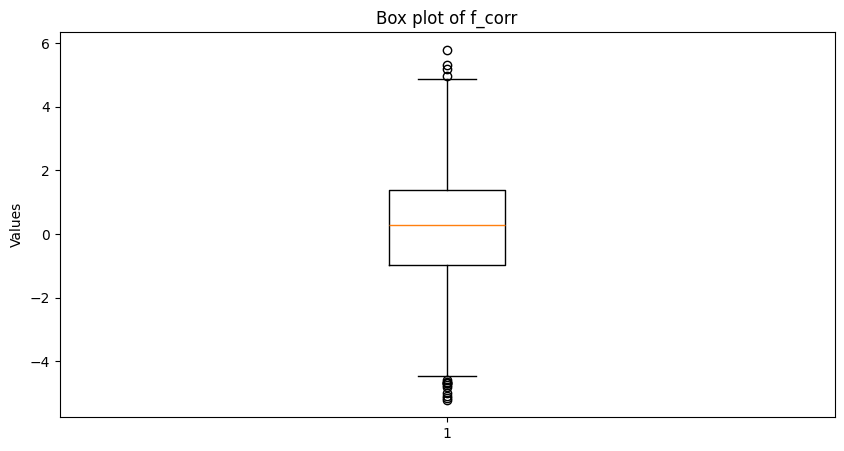

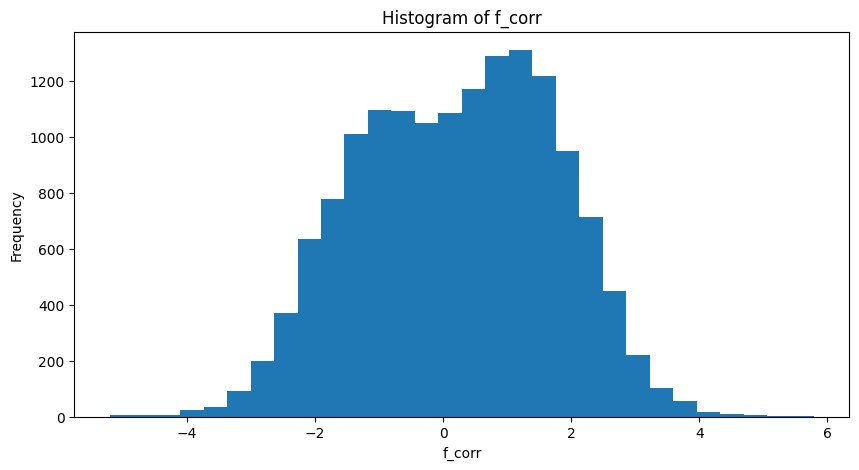

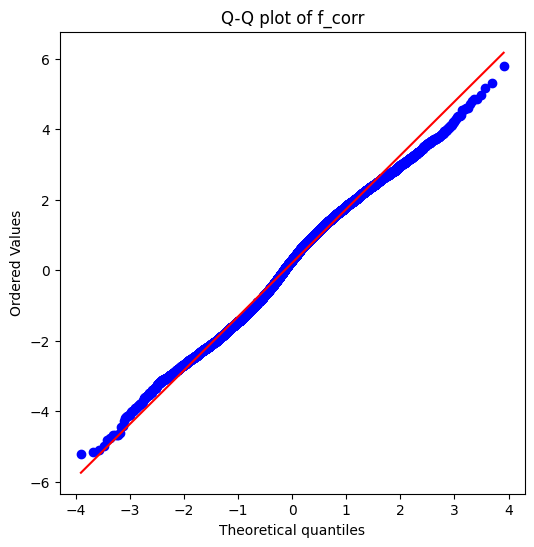

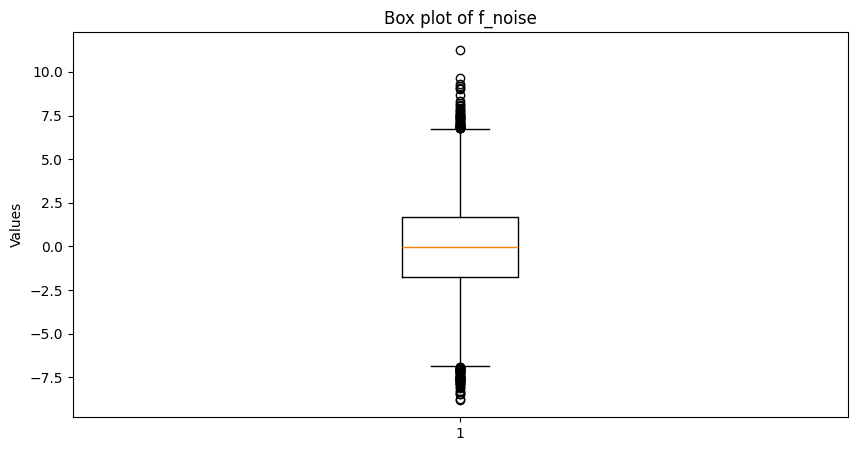

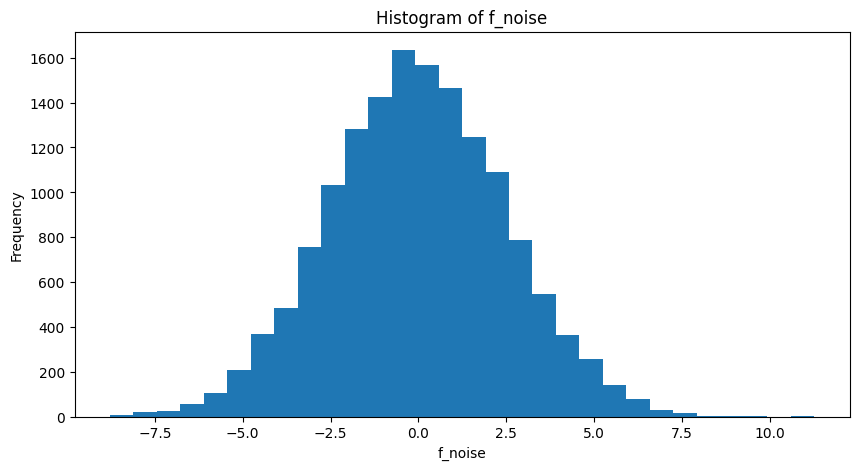

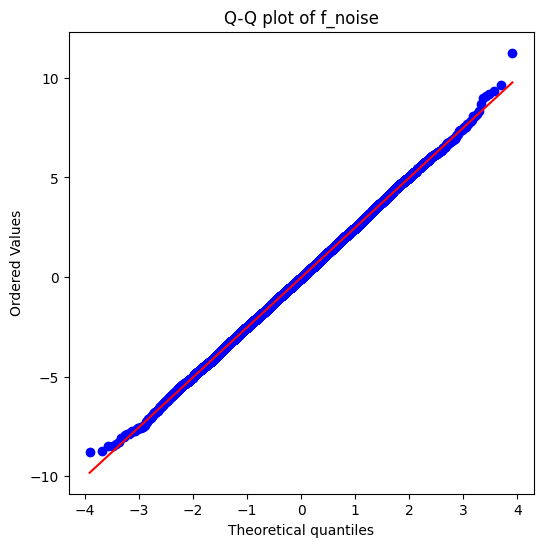

=== Numeric columns distribution report (skew/kurtosis + normality tests) ===


,column,n,skewness,kurtosis_excess,anderson_stat,anderson_crit_5pct,shapiro_stat,shapiro_p,dagostino_stat,dagostino_p
1,x2,15000,-0.112941,-1.024955,277.838500,0.787,0.954229,5.725484e-37,3968.136192,0.000000e+00
0,x1,15000,-0.008623,-0.738046,101.701842,0.787,0.976100,3.578000e-28,949.027693,8.341706e-207
2,f_corr,15000,-0.101464,-0.589444,49.110340,0.787,0.990641,1.095576e-17,485.757248,3.304866e-106
3,f_noise,15000,0.026603,-0.001158,0.416141,0.787,0.999575,3.553578e-01,1.770129,4.126876e-01


In [12]:
df_report(dataset_three, dataset_name='hw07_ds3')

# Выбор масштабирования признаков

Для каждого датасета масштабирование признаков подбиралось **осознано**, на основе проведенных тестов.
Выбор алгоритма масштабирования важно для корректной работе моделей кластеризации на основе расстояний между объектами.

Были выбранны следующие критерии выбора масштабирования:
- **Асиметрия** (skewness): отражает перекос распределния. Если асиметрия больше 1 или меньше -1, то распределение считается сильно асимметричным.
- **Куртозис** (kurtosis_excess): отражает "островершинность" распределения. Если куртозис больше 3, то распределение считается острое.
- **Тест Андерсона-Дарлинга** (Anderson-Darling test): статистический тест на нормальность распределения. Чем меньше значение статистики, тем больше вероятность того, что выборка взята из нормального распределения.

При больших данных (наш случай, 8k-15k строк) p-значение классических тестов на нормальность (Шапиро-Уилка, Агостино-Пирсона) всегда будет близко к нулю, поэтому они были отброшены при рассмотрения и остались только для обратной совместимости.

Логика выбора масштабирования следующая:
- Для RobustScaler: если существенно отклоняется от нормально распределения, обладает тяжелами хвостами или плоской формой, потенциально содержит выбросы. RobustScaler устойчив к выбросам и не зависит от параметров распределения.
- Для StandardScaler: если данные примерно нормально распределены, без значительных выбросов. StandardScaler центрирует данные и масштабирует их до единичной дисперсии, что полезно для алгоритмов, предполагающих нормальное распределение.

Для каждого датасета были получены следующие результаты тестов и выбран соответствующий метод масштабирования признаков:
- dataset-01: RobustScaler для колонок `f01`, `f02`, `f03`, `f04`, `f05`, `f06`. StandardScaler для колонок `f07`, `f08`.
- dataset-02: RobustScaler для колонок `x1`, `x2`. StandardScaler для колонок `z_noise`.
- dataset-03: RobustScaler для колонок `x1`, `x2`, `f_corr`. StandardScaler для колонок `f_noise`.

In [13]:
# loading configs
config_one = load_config(CONFIG_DIR / "base.toml", CONFIG_DIR / 'data' / "dataset-01.toml")
config_two = load_config(CONFIG_DIR / "base.toml", CONFIG_DIR / 'data' / "dataset-02.toml")
config_three = load_config(CONFIG_DIR / "base.toml", CONFIG_DIR / 'data' / "dataset-03.toml")

In [14]:
def build_preprocessor(config: PreprocessConfig) -> ColumnTransformer:
    scaling_steps = []
    for scaling_cfg in config.scaling:
        method = scaling_cfg.get("method", "none")
        columns = scaling_cfg.get("columns", [])

        if method == "none":
            continue

        scaling_steps.append((method, columns))

    if not scaling_steps:
        raise ValueError("No scaling steps defined in config")

    # grouping columns by method
    method_to_cols: Dict[str, list[str]] = {}
    for method, cols in scaling_steps:
        if not cols:
            # if not set, use this method for all columns
            method_to_cols = {method: []}
            break
        method_to_cols.setdefault(method, []).extend(cols)

    # building ColumnTransformer
    transformers = []
    for method, cols in method_to_cols.items():
        if method == "standard":
            pipe = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ])
        elif method == "robust":
            pipe = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", RobustScaler()),
            ])
        else:
            raise ValueError(f"Unknown scaling method: {method}")

        transformers.append((method, pipe, cols))

    preprocessor = ColumnTransformer(transformers, verbose_feature_names_out=False)
    return preprocessor

In [15]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title, dataset_name="hw_dataset"):
    fig, ax = plt.subplots(figsize=(7, 5))

    scatter = ax.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)

    ax.set_title(title)
    ax.set_xlabel("dim-1")
    ax.set_ylabel("dim-2")
    ax.grid(True, alpha=0.2)

    ax.legend(
        *scatter.legend_elements(),
        title="Clusters",
        loc="upper left",
        bbox_to_anchor=(1.02, 1)
    )

    fig.subplots_adjust(right=0.75)

    fig.savefig(
        FIGURES_DIR / f"{_safe_filename(dataset_name)}_{_safe_filename(title)}.png",
        dpi=150
    )
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))


In [16]:
def eval_kmeans_grid(X_data, ks, config):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        kmeans_pipeline = Pipeline([
            ("pre", build_preprocessor(config.preprocess)),
            ("kmeans", model)
        ])

        labels = kmeans_pipeline.fit_predict(X_data)
        metrics = safe_cluster_metrics(X_data, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

In [17]:
def display_kmeans_figures(results, dataset_name="hw_dataset"):
    # Быстрый график silhouette по k (если silhouette считалась)
    ks = [r["params"]["k"] for r in results]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in results]

    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title(f"KMeans ({dataset_name}): silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.savefig(FIGURES_DIR / f"{dataset_name}_kmeans_silhouette_vs_k.png", bbox_inches="tight", dpi=150)
    plt.show()

    # Инерция (elbow) – как эвристика
    inertia = [r["inertia"] for r in results]
    plt.figure(figsize=(7, 4))
    plt.plot(ks, inertia, marker="o")
    plt.title(f"KMeans ({dataset_name}): inertia vs k (elbow heuristic)")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.grid(True, alpha=0.25)
    plt.savefig(FIGURES_DIR / f"{dataset_name}_kmeans_inertia_vs_k.png", bbox_inches="tight", dpi=150)
    plt.show()


In [18]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

In [19]:
def eval_dbscan_grid(X_data, eps_list, min_samples_list, config):
    results = []

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)

            dbscan_pipeline = Pipeline([
                ("pre", build_preprocessor(config.preprocess)),
                ("dbscan", model)
            ])

            labels = dbscan_pipeline.fit_predict(X_data)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_data[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

In [20]:
def get_best_dbscan_config(dbscan_results):
    # Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
    valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
    print("Valid DBSCAN configs:", len(valid))

    # Сортировка по silhouette
    valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
    for r in valid_sorted[:8]:
        print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])

    print('Best DBSCAN config:')
    best_dbscan = valid_sorted[0] if valid_sorted else None
    print(best_dbscan["params"] if best_dbscan else "No valid config found")
    return best_dbscan

In [21]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

def evaluate_results(best_kmeans, best_dbscan):
    print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
    if best_dbscan is not None:
        print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)

In [22]:
def visualize_best(X_scaled, best_kmeans, best_dbscan, dataset_name="hw_dataset"):
    X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

    # KMeans best
    plot_2d_embedding(
        X_plot2d, best_kmeans["labels"],
        title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}",
        dataset_name=dataset_name
    )

    # DBSCAN best (if exists)
    if best_dbscan is not None:
        plot_2d_embedding(
            X_plot2d, best_dbscan["labels"],
            title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan['params']} (noise=-1)",
            dataset_name=dataset_name
        )

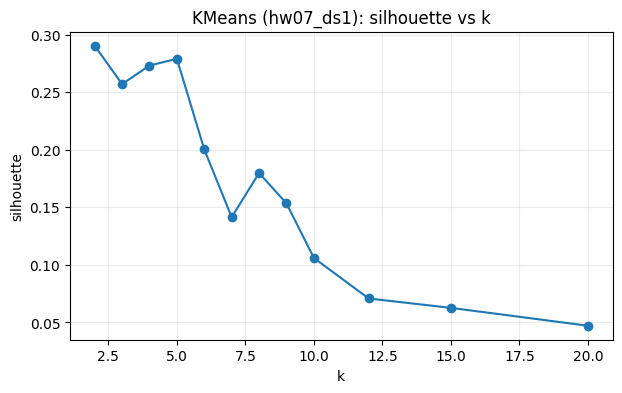

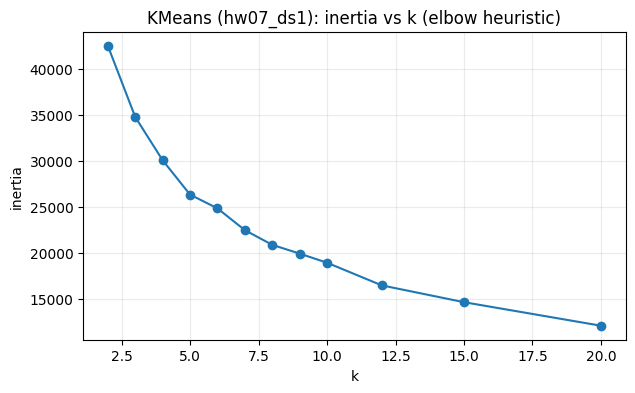

Best KMeans (dataset_one) silhouette: 0.2904816863873133
Valid DBSCAN configs: 32
{'eps': 0.8, 'min_samples': 20} sil= 0.323 noise= 0.014 clusters= 4
{'eps': 0.8, 'min_samples': 10} sil= 0.322 noise= 0.007 clusters= 4
{'eps': 0.8, 'min_samples': 5} sil= 0.321 noise= 0.004 clusters= 4
{'eps': 0.8, 'min_samples': 3} sil= 0.307 noise= 0.003 clusters= 5
{'eps': 0.5, 'min_samples': 20} sil= 0.305 noise= 0.253 clusters= 6
{'eps': 2.0, 'min_samples': 3} sil= 0.29 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 5} sil= 0.29 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 10} sil= 0.29 noise= 0.0 clusters= 2
Best DBSCAN config:
{'eps': 0.8, 'min_samples': 20}
BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.29
  davies_bouldin: 1.055
  calinski_harabasz: 4367.7
  inertia: 42535.6
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.8, 'min_samples': 20}
n_clusters: 4
noise_frac: 0.014  non-noise: 11835
metrics:
  silhouette

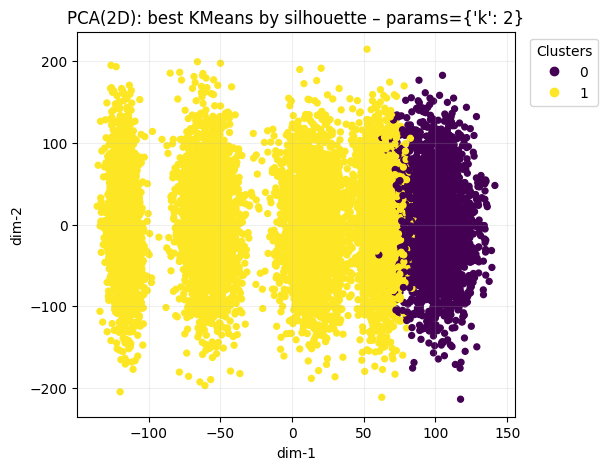

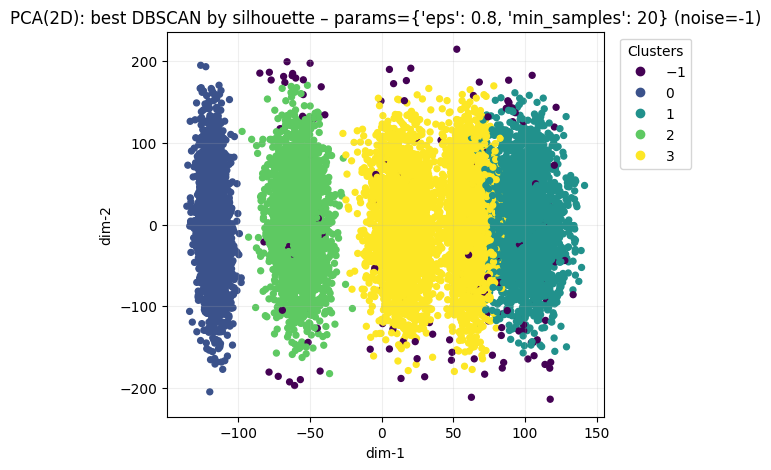

In [23]:
first_kmeans_results = eval_kmeans_grid(dataset_one, config_one.search.grids.kmeans.ks, config_one)
display_kmeans_figures(first_kmeans_results, dataset_name="hw07_ds1")
best_kmeans_one, best_sil_one = pick_best_by_silhouette(first_kmeans_results)
print("Best KMeans (dataset_one) silhouette:", best_sil_one)
first_dbscan_results = eval_dbscan_grid(dataset_one, config_one.search.grids.dbscan.eps, config_one.search.grids.dbscan.min_samples, config_one)
best_dbscan_one = get_best_dbscan_config(first_dbscan_results)
evaluate_results(best_kmeans_one, best_dbscan_one)
visualize_best(dataset_one, best_kmeans_one, best_dbscan_one, dataset_name="hw07_ds1")

Для dataset-01 KMeans с k=2 формирует два крупных кластера, что приводит к потере локальной структуры данных. DBSCAN с параметрами eps=0.8 и min_samples=20 выявляет четыре плотностных кластера и небольшую долю шума, что согласуется с визуальной структурой данных в PCA-проекции.

Несмотря на более высокий Davies–Bouldin индекс, DBSCAN демонстрирует более высокий silhouette-score и значительно лучший Calinski–Harabasz score, поэтому именно он был выбран как лучший алгоритм для данного датасета.

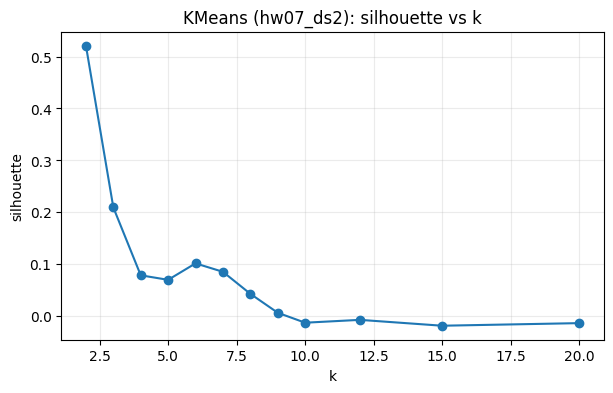

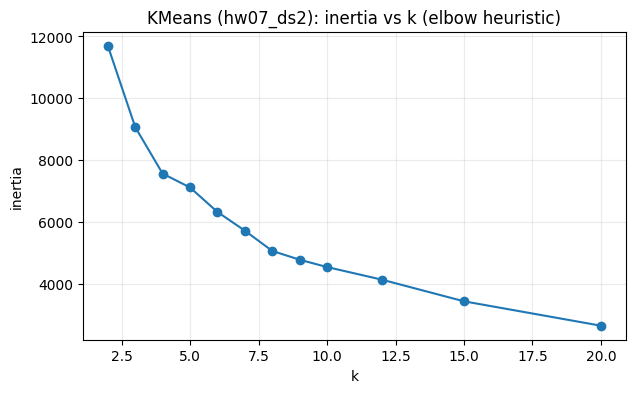

Best KMeans (dataset_two) silhouette: 0.5208194538492243
Valid DBSCAN configs: 3
{'eps': 0.5, 'min_samples': 3} sil= -0.299 noise= 0.012 clusters= 4
{'eps': 0.5, 'min_samples': 10} sil= -0.407 noise= 0.049 clusters= 4
{'eps': 0.5, 'min_samples': 5} sil= -0.564 noise= 0.019 clusters= 11
Best DBSCAN config:
{'eps': 0.5, 'min_samples': 3}
BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.521
  davies_bouldin: 0.647
  calinski_harabasz: 13198.0
  inertia: 11700.6
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.5, 'min_samples': 3}
n_clusters: 4
noise_frac: 0.012  non-noise: 7906
metrics:
  silhouette: -0.299
  davies_bouldin: 0.829
  calinski_harabasz: 5.8


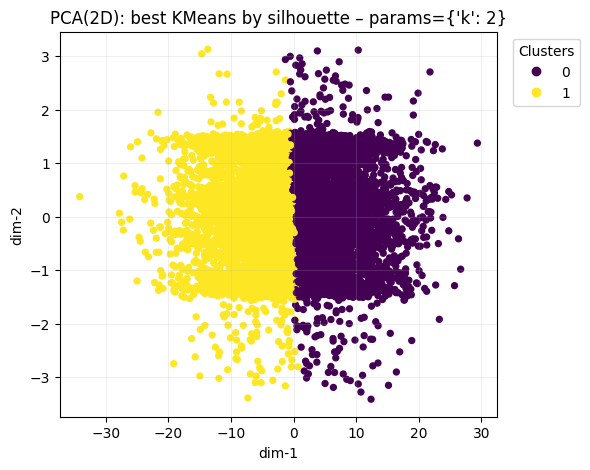

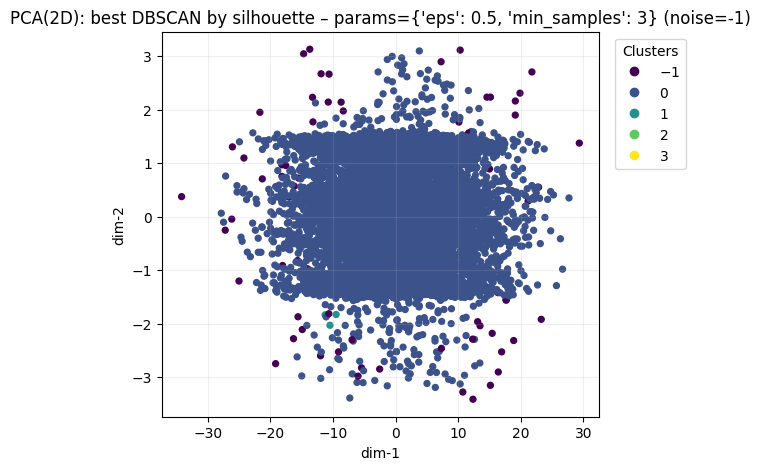

In [24]:
second_kmeans_results = eval_kmeans_grid(dataset_two, config_two.search.grids.kmeans.ks, config_two)
display_kmeans_figures(second_kmeans_results, dataset_name="hw07_ds2")
best_kmeans_two, best_sil_two = pick_best_by_silhouette(second_kmeans_results)
print("Best KMeans (dataset_two) silhouette:", best_sil_two)
second_dbscan_results = eval_dbscan_grid(dataset_two, config_two.search.grids.dbscan.eps, config_two.search.grids.dbscan.min_samples, config_two)
best_dbscan_two = get_best_dbscan_config(second_dbscan_results)
evaluate_results(best_kmeans_two, best_dbscan_two)
visualize_best(dataset_two, best_kmeans_two, best_dbscan_two, dataset_name="hw07_ds2")

Для dataset-02 KMeans с k=2 демонстрирует чёткое разделение данных, что подтверждается PCA-визуализацией и высокими значениями silhouette-score и Calinski–Harabasz index.

DBSCAN, напротив, не выявляет устойчивой плотностной структуры: большинство точек объединяется в один кластер, а silhouette-score принимает отрицательное значение. Это указывает на несоответствие предпосылок DBSCAN структуре данных.

В результате KMeans был выбран как лучший алгоритм для данного датасета.

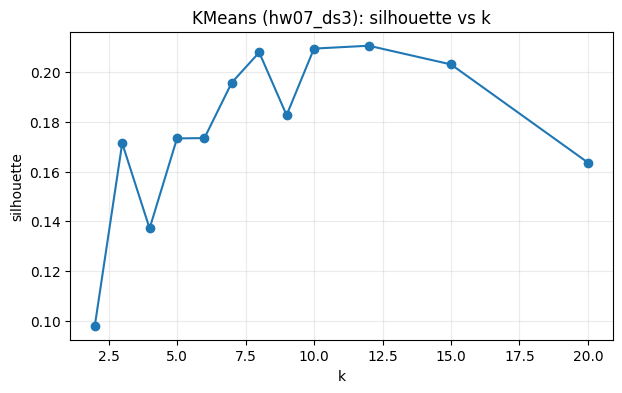

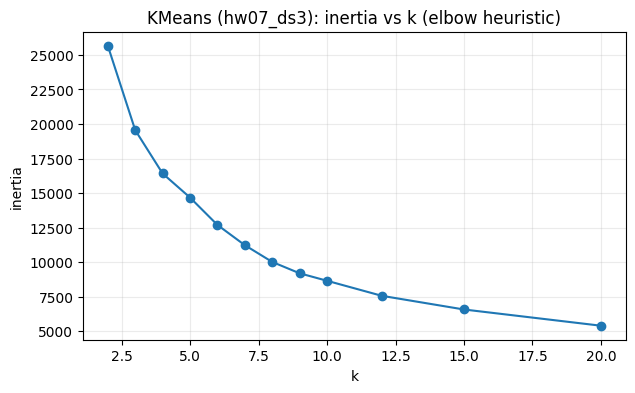

Best KMeans (dataset_three) silhouette: 0.21071724362315636
Valid DBSCAN configs: 1
{'eps': 0.5, 'min_samples': 3} sil= 0.208 noise= 0.004 clusters= 3
Best DBSCAN config:
{'eps': 0.5, 'min_samples': 3}
BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 12}
n_clusters: 12
metrics:
  silhouette: 0.211
  davies_bouldin: 1.517
  calinski_harabasz: 6526.9
  inertia: 7572.8
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.5, 'min_samples': 3}
n_clusters: 3
noise_frac: 0.004  non-noise: 14943
metrics:
  silhouette: 0.208
  davies_bouldin: 0.65
  calinski_harabasz: 10.2


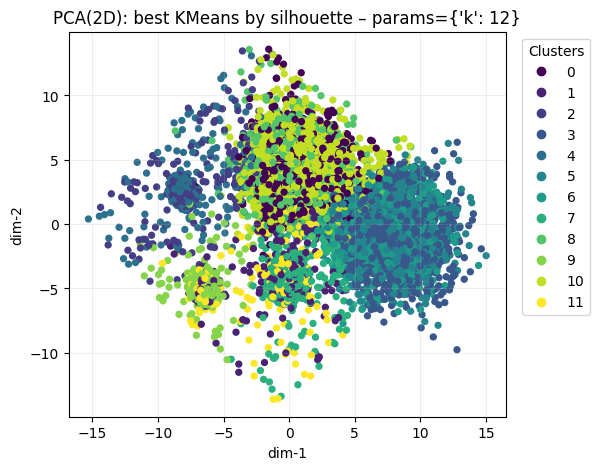

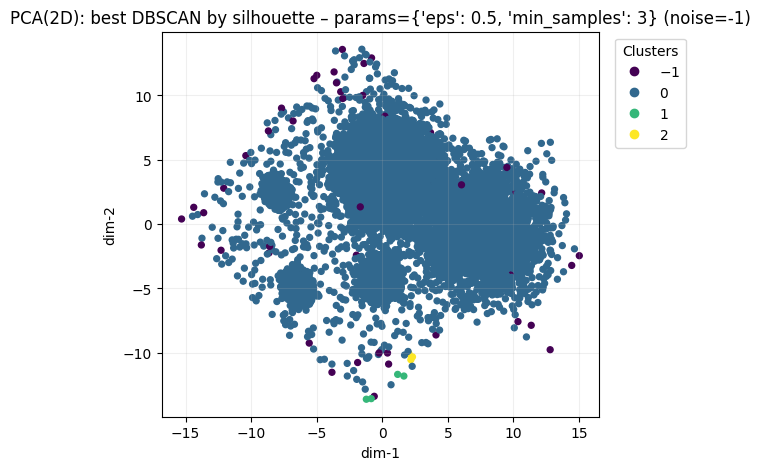

In [25]:
third_kmeans_results = eval_kmeans_grid(dataset_three, config_three.search.grids.kmeans.ks, config_three)
display_kmeans_figures(third_kmeans_results, dataset_name="hw07_ds3")
best_kmeans_three, best_sil_three = pick_best_by_silhouette(third_kmeans_results)
print("Best KMeans (dataset_three) silhouette:", best_sil_three)
third_dbscan_results = eval_dbscan_grid(dataset_three, config_three.search.grids.dbscan.eps, config_three.search.grids.dbscan.min_samples, config_three)
best_dbscan_three = get_best_dbscan_config(third_dbscan_results)
evaluate_results(best_kmeans_three, best_dbscan_three)
visualize_best(dataset_three, best_kmeans_three, best_dbscan_three, dataset_name="hw07_ds3")

Dataset-03 представляет собой сложный случай кластеризации с кластерами разной плотности и фоновым шумом. KMeans демонстрирует рост silhouette-score при увеличении числа кластеров, однако PCA-визуализация показывает сильное перекрытие и потерю интерпретируемости.

DBSCAN, в свою очередь, выявляет несколько плотностных областей и небольшую долю шума, но не способен корректно разделить кластеры разной плотности с одним параметром eps.

В результате качество кластеризации остаётся ограниченным для обоих методов, что отражается в низких значениях silhouette-score.

# Устойчивость

Для проверки устойчивости на dataset-03 выполнены две процедуры.

- устойчивость KMeans к подвыборкам данных: 5 запусков на случайных 80% объектов с оценкой сходства разбиений по ARI на пересечениях;
- чувствительность DBSCAN к гиперпараметрам: локальный перебор eps и min_samples вокруг найденного оптимума с анализом числа кластеров, доли шума и внутренних метрик на non-noise точках.

Это позволяет оценить, насколько результаты кластеризации зависят от случайности выборки и небольших изменений параметров.

In [26]:
k_best = best_kmeans_three.get("n_clusters")
pre = build_preprocessor(config_three.preprocess)
X_scaled = pre.fit_transform(dataset_three)
n = X_scaled.shape[0]
rng = np.random.default_rng(RANDOM_STATE)

n_runs = 5
frac = 0.8
subset_size = int(n * frac)

subsets = []
labels = []
silhs = []

for t in range(n_runs):
    idx = rng.choice(n, size=subset_size, replace=False)
    idx.sort()
    km = KMeans(n_clusters=k_best, random_state=100 + t, n_init=10)
    y = km.fit_predict(X_scaled[idx])

    subsets.append(idx)
    labels.append(y)
    silhs.append(silhouette_score(X_scaled[idx], y))

# ARI
aris = []
pairs = []
for i in range(n_runs):
    for j in range(i + 1, n_runs):
        si, sj = subsets[i], subsets[j]
        inter = np.intersect1d(si, sj, assume_unique=True)
        if inter.size < 50:
            continue

        pos_i = np.searchsorted(si, inter)
        pos_j = np.searchsorted(sj, inter)

        ari = adjusted_rand_score(labels[i][pos_i], labels[j][pos_j])
        aris.append(ari)
        pairs.append((i, j, inter.size))

print("=== Subsampling stability (KMeans, dataset-03) ===")
print(f"k={k_best}, runs={n_runs}, subsample={frac:.0%} ({subset_size}/{n})")
print(f"Silhouette on subsamples: mean={np.mean(silhs):.3f} ± {np.std(silhs):.3f}")

if len(aris) == 0:
    print("ARI: недостаточно пересечений между подвыборками для оценки.")
else:
    print(f"ARI over intersections: mean={np.mean(aris):.3f}, min={np.min(aris):.3f}, max={np.max(aris):.3f}")
    print("Intersection sizes (i, j, |intersection|):", pairs)


=== Subsampling stability (KMeans, dataset-03) ===
k=12, runs=5, subsample=80% (12000/15000)
Silhouette on subsamples: mean=0.284 ± 0.002
ARI over intersections: mean=0.797, min=0.668, max=0.932
Intersection sizes (i, j, |intersection|): [(0, 1, 9590), (0, 2, 9566), (0, 3, 9589), (0, 4, 9597), (1, 2, 9621), (1, 3, 9589), (1, 4, 9595), (2, 3, 9609), (2, 4, 9629), (3, 4, 9654)]


In [27]:
def dbscan_metrics_non_noise(X_arr, labels):
    labels = np.asarray(labels)
    noise_frac = float(np.mean(labels == -1))
    mask = labels != -1
    X_nn = X_arr[mask]
    y_nn = labels[mask]
    n_clusters = int(len(set(y_nn)))

    if X_nn.shape[0] < 10 or n_clusters < 2:
        return {
            "n_clusters": n_clusters,
            "noise_frac": noise_frac,
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None,
            "n_non_noise": int(X_nn.shape[0]),
        }

    return {
        "n_clusters": n_clusters,
        "noise_frac": noise_frac,
        "silhouette": float(silhouette_score(X_nn, y_nn)),
        "davies_bouldin": float(davies_bouldin_score(X_nn, y_nn)),
        "calinski_harabasz": float(calinski_harabasz_score(X_nn, y_nn)),
        "n_non_noise": int(X_nn.shape[0]),
    }

In [28]:
dbscan_params: dict = best_dbscan_three["params"]
eps0 = dbscan_params.get("eps", 0.5)
min_samples0 = dbscan_params.get("min_samples", 3)

# Сетка вокруг eps0 и min_samples0
eps_grid = [round(eps0 * m, 3) for m in [0.7, 0.85, 1.0, 1.15, 1.3]]
min_samples_grid = sorted(set([max(2, min_samples0 - 2), max(2, min_samples0 - 1), min_samples0, min_samples0 + 1, min_samples0 + 2]))

results = []
for eps in eps_grid:
    for ms in min_samples_grid:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X_scaled)
        m = dbscan_metrics_non_noise(X_scaled, labels)
        results.append({"eps": eps, "min_samples": ms, **m})

print("=== DBSCAN sensitivity (dataset-03) ===")
print(f"Base: eps={eps0}, min_samples={min_samples0}")
for r in results:
    print(
        f"eps={r['eps']}, min_samples={r['min_samples']}: "
        f"clusters={r['n_clusters']}, noise={r['noise_frac']:.3f}, non-noise={r['n_non_noise']}, "
        f"sil={None if r['silhouette'] is None else round(r['silhouette'], 3)}, "
        f"DB={None if r['davies_bouldin'] is None else round(r['davies_bouldin'], 3)}, "
        f"CH={None if r['calinski_harabasz'] is None else round(r['calinski_harabasz'], 1)}"
    )

valid = [r for r in results if r["silhouette"] is not None]
if valid:
    sils = [r["silhouette"] for r in valid]
    noises = [r["noise_frac"] for r in valid]
    clusters = [r["n_clusters"] for r in valid]
    print("\nSummary over valid configs:")
    print(f"silhouette: mean={np.mean(sils):.3f} ± {np.std(sils):.3f}")
    print(f"noise_frac: mean={np.mean(noises):.3f} ± {np.std(noises):.3f}")
    print(f"n_clusters: min={np.min(clusters)}, max={np.max(clusters)}")
else:
    print("\nNo valid configs (>=2 clusters among non-noise points) in this local grid.")


=== DBSCAN sensitivity (dataset-03) ===
Base: eps=0.5, min_samples=3
eps=0.35, min_samples=2: clusters=46, noise=0.016, non-noise=14760, sil=-0.434, DB=0.701, CH=7.6
eps=0.35, min_samples=3: clusters=17, noise=0.020, non-noise=14702, sil=-0.29, DB=0.738, CH=10.5
eps=0.35, min_samples=4: clusters=8, noise=0.024, non-noise=14637, sil=-0.185, DB=0.77, CH=11.3
eps=0.35, min_samples=5: clusters=3, noise=0.028, non-noise=14586, sil=-0.012, DB=0.944, CH=10.6
eps=0.425, min_samples=2: clusters=21, noise=0.006, non-noise=14903, sil=-0.268, DB=0.654, CH=6.6
eps=0.425, min_samples=3: clusters=5, noise=0.009, non-noise=14871, sil=-0.005, DB=0.645, CH=9.4
eps=0.425, min_samples=4: clusters=5, noise=0.010, non-noise=14849, sil=-0.099, DB=0.81, CH=7.0
eps=0.425, min_samples=5: clusters=4, noise=0.012, non-noise=14823, sil=0.068, DB=0.825, CH=11.5
eps=0.5, min_samples=2: clusters=6, noise=0.003, non-noise=14949, sil=0.002, DB=0.619, CH=9.0
eps=0.5, min_samples=3: clusters=3, noise=0.004, non-noise=149

**Устойчивость KMeans к подвыборкам данных**

Для лучшей конфигурации KMeans (k = 12) было выполнено 5 запусков алгоритма на случайных подвыборках, содержащих 80% объектов. Сходство разбиений оценивалось с помощью Adjusted Rand Index (ARI) на пересечениях подвыборок.

Среднее значение silhouette-score на подвыборках составило *0.284* с крайне малым разбросом (+-0.002), что указывает на стабильное качество кластеризации. Средний ARI между разбиениями равен 0.797 (минимум 0.668, максимум 0.932), что свидетельствует о высокой согласованности кластеров при изменении состава данных. Таким образом, разбиение KMeans является устойчивым к подвыборкам.

**Чувствительность DBSCAN к гиперпараметрам**

Для DBSCAN была проанализирована чувствительность к параметрам eps и min_samples в окрестности найденного оптимума. Наблюдается сильная зависимость результатов от небольших изменений параметров: число кластеров варьируется в широком диапазоне, silhouette-score демонстрирует высокий разброс, а при увеличении eps происходит схлопывание решения в один кластер.

Отсутствие устойчивого диапазона параметров указывает на высокую чувствительность DBSCAN и ограниченную применимость данного метода для dataset-03, что согласуется с наличием кластеров разной плотности.

# Сохранение результатов

In [29]:
metrics_summary: dict[str, dict[str, float]] = {}
best_configs: dict[str, dict[str, Any]] = {}

In [30]:
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

In [31]:
for dataset_name, dataset, config, best_kmeans, best_dbscan in [
	("hw07_ds1", dataset_one, config_one, best_kmeans_one, best_dbscan_one),
	("hw07_ds2", dataset_two, config_two, best_kmeans_two, best_dbscan_two),
	("hw07_ds3", dataset_three, config_three, best_kmeans_three, best_dbscan_three),
]:
	artifacts_dir = ARTIFACTS_DIR  # noqa: F821
	labels_path = _ensure_dir(artifacts_dir / "labels")

	# select best model between kmeans and dbscan by silhouette
	best_model = best_kmeans
	if best_dbscan is not None:
		sil_km = best_kmeans["metrics"]["silhouette"] if best_kmeans["metrics"] and best_kmeans["metrics"]["silhouette"] is not None else -np.inf
		sil_db = best_dbscan["metrics"]["silhouette"] if best_dbscan["metrics"] and best_dbscan["metrics"]["silhouette"] is not None else -np.inf
		if sil_db > sil_km:
			best_model = best_dbscan
	print(f"Saving labels for dataset {dataset_name}, best model: {best_model['algo']} with params {best_model['params']}")

	# store labels into csv
	labels_df = pd.DataFrame({
		"sample_id": dataset.index,
		"cluster_label": best_model["labels"],
	})
	labels_df.to_csv(labels_path / f"labels_{dataset_name}.csv", index=False)

	# collect metrics (from all best models)
	for model in [best_kmeans, best_dbscan if best_dbscan is not None else None]:
		if model is None:
			continue
		model_name = model["algo"]
		if model_name not in metrics_summary:
			metrics_summary[model_name] = {}
		if dataset_name not in metrics_summary[model_name]:
			metrics_summary[model_name][dataset_name] = {}
		metrics_summary[model_name][dataset_name] = {
			"silhouette": model["metrics"]["silhouette"] if model["metrics"] and model["metrics"]["silhouette"] is not None else np.nan,
			"davies_bouldin": model["metrics"]["davies_bouldin"] if model["metrics"] and model["metrics"]["davies_bouldin"] is not None else np.nan,
			"calinski_harabasz": model["metrics"]["calinski_harabasz"] if model["metrics"] and model["metrics"]["calinski_harabasz"] is not None else np.nan,
			"n_clusters": model.get("n_clusters", 0),
			"noise_frac": model.get("noise_frac", 0.0) if model["algo"] == "dbscan" else 0.0,
		}
		# now collect best config
		if model_name not in best_configs:
			best_configs[model_name] = {}
		if dataset_name not in best_configs[model_name]:
			best_configs[model_name][dataset_name] = {}
		best_configs[model_name][dataset_name] = model["params"]

save_json(metrics_summary, Path(artifacts_dir) / "metrics_summary.json")
save_json(best_configs, Path(artifacts_dir) / "best_configs.json")

Saving labels for dataset hw07_ds1, best model: dbscan with params {'eps': 0.8, 'min_samples': 20}
Saving labels for dataset hw07_ds2, best model: kmeans with params {'k': 2}
Saving labels for dataset hw07_ds3, best model: kmeans with params {'k': 12}
